<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.datasets import load_diabetes, load_boston
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# Load the data
house = pd.read_csv('./housing.csv')

In [5]:
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
0   1          60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2003          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA      PConc       Gd       TA           No          GLQ         706          Unf           0        150          856    GasA        Ex          Y      SBrkr       856       854             0       1710             1             0         2         1             3             1          Gd             8        Typ           0         NaN     Attchd       2003.0          RFn           2         548         TA         TA          Y           0           61              0          0            0         0    NaN   NaN         NaN        0       2    2008       WD        Normal     208500
1   2          20       RL         80.0     9600   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story            6            8       1976          1976     Gable  CompShg     MetalSd     MetalSd       None         0.0        TA        TA     CBlock       Gd       TA           Gd          ALQ         978          Unf           0        284         1262    GasA        Ex          Y      SBrkr      1262         0             0       1262             0             1         2         0             3             1          TA             6        Typ           1          TA     Attchd       1976.0          RFn           2         460         TA         TA          Y         298            0              0          0            0         0    NaN   NaN         NaN        0       5    2007       WD        Normal     181500
2   3          60       RL         68.0    11250   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2001          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA      PConc       Gd       TA           Mn          GLQ         486          Unf           0        434          920    GasA        Ex          Y      SBrkr       920       866             0       1786             1             0         2         1             3             1          Gd             6        Typ           1          TA     Attchd       2001.0          RFn           2         608         TA         TA          Y           0           42              0          0            0         0    NaN   NaN         NaN        0       9    2008       WD        Normal     223500
3   4          70       RL         60.0     9550   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story            7            5       1915          1970     Gable  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA     BrkTil       TA       Gd           No          ALQ         216          Unf           0        540          756   

In [6]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
  

In [7]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [8]:
house.PoolQC.value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [9]:
house.GarageType.value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [10]:
#Fill NaN Pool QC values with 0 so they can be dummified.
house['PoolQC'].fillna(0, inplace=True)

In [11]:
#Fill NaN lot frontage values with 0 as they are possibly rear properties.
house['LotFrontage'].fillna(0, inplace=True)

In [12]:
house['MasVnrArea'].fillna(0, inplace=True)

In [13]:
house['MasVnrArea'].fillna(0, inplace=True)

In [14]:
house.GarageYrBlt.fillna(house.GarageYrBlt.mean(),inplace=True)
house.dropna(subset=['Electrical'], inplace=True)

In [15]:
#Fill all remaining NaN values with 'none'
house=house.fillna('none')

In [16]:
house.MSZoning.value_counts()

RL         1150
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [17]:
# Remove I and C zoned properties
house=house[(house['MSZoning']!='I')&(house['MSZoning']!='C (all)')&(house['MSZoning']!='A')]

In [18]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 0 to 1459
Data columns (total 81 columns):
Id               1449 non-null int64
MSSubClass       1449 non-null int64
MSZoning         1449 non-null object
LotFrontage      1449 non-null float64
LotArea          1449 non-null int64
Street           1449 non-null object
Alley            1449 non-null object
LotShape         1449 non-null object
LandContour      1449 non-null object
Utilities        1449 non-null object
LotConfig        1449 non-null object
LandSlope        1449 non-null object
Neighborhood     1449 non-null object
Condition1       1449 non-null object
Condition2       1449 non-null object
BldgType         1449 non-null object
HouseStyle       1449 non-null object
OverallQual      1449 non-null int64
OverallCond      1449 non-null int64
YearBuilt        1449 non-null int64
YearRemodAdd     1449 non-null int64
RoofStyle        1449 non-null object
RoofMatl         1449 non-null object
Exterior1st      1449 non

In [19]:
house.nunique()

Id               1449
MSSubClass         15
MSZoning            4
LotFrontage       111
LotArea          1069
Street              2
Alley               3
LotShape            4
LandContour         4
Utilities           2
LotConfig           5
LandSlope           3
Neighborhood       25
Condition1          9
Condition2          8
BldgType            5
HouseStyle          8
OverallQual        10
OverallCond         9
YearBuilt         112
YearRemodAdd       61
RoofStyle           6
RoofMatl            8
Exterior1st        15
Exterior2nd        16
MasVnrType          5
MasVnrArea        327
ExterQual           4
ExterCond           5
Foundation          6
BsmtQual            5
BsmtCond            5
BsmtExposure        5
BsmtFinType1        7
BsmtFinSF1        636
BsmtFinType2        7
BsmtFinSF2        144
BsmtUnfSF         776
TotalBsmtSF       719
Heating             6
HeatingQC           5
CentralAir          2
Electrical          5
1stFlrSF          745
2ndFlrSF          413
LowQualFin

In [20]:
renovatable = ['OverallQual','OverallCond','ExterQual','ExterCond','Exterior1st','Exterior2nd','BsmtCond','BsmtFinType1','BsmtFinType2','RoofMatl',
               'KitchenQual','FireplaceQu','GarageFinish','GarageQual','GarageCond','WoodDeckSF','Fence','HeatingQC',
               'CentralAir','Electrical','Heating','YrSold','SalePrice']

In [21]:
fixed = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour',
         'Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
         'YearBuilt','YearRemodAdd','RoofStyle','MasVnrType','MasVnrArea',
         'Foundation','BsmtQual','BsmtExposure','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
         '2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
         'KitchenAbvGr','TotRmsAbvGrd','Functional','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea',
         'PavedDrive','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','PoolQC','MiscFeature',
         'MiscVal','YrSold','SalePrice','SaleCondition'] 

#Check there are no double ups in the list. 
#nb:sale price and Year Sold will be removed from the list following the test/train split
for i in renovatable:
    if i in fixed:
        print(i) 

YrSold
SalePrice


In [22]:
house['Fence'].value_counts()

none     1171
MnPrv     155
GdPrv      59
GdWo       53
MnWw       11
Name: Fence, dtype: int64

In [23]:
house['MSZoning'].value_counts()

RL    1150
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [24]:
house['Alley'].value_counts()

none    1360
Grvl      50
Pave      39
Name: Alley, dtype: int64

In [25]:
house.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea       MiscVal       MoSold       YrSold      SalePrice
count  1449.000000  1449.000000  1449.000000    1449.000000  1449.000000  1449.000000  1449.000000   1449.000000  1449.000000  1449.000000  1449.000000  1449.000000  1449.000000  1449.000000  1449.000000   1449.000000  1449.000000   1449.000000   1449.000000  1449.000000  1449.000000   1449.000000   1449.000000   1449.000000  1449.000000  1449.000000  1449.000000  1449.000000  1449.000000  1449.000000    1449.000000  1449.000000  1449.000000  1449.000000   1449.000000  1449.000000  1449.000000    1449.000000
mean    730.916494    56.887509    57.529331   10524.376121     6.115252     5.582471  1971.569358   1985.034507   103.899931   445.469979    46.902692   567.502415  1059.875086  1165.056591   347.192547      5.534852  1517.783989      0.427881      0.057281     1.568668     0.384403      2.870255      1.046239      6.521739     0.616977  1978.601095     1.770186   473.328502    94.823326    46.570048      21.551415     3.435473    15.106970     2.779848     43.395445     6.313320  2007.812284  181664.710835
std     421.354997    42.275264    34.729529   10015.620536     1.373022     1.107606    30.019438     20.551315   181.192098   456.361401   161.879639   442.711533   439.000040   386.628808   437.177499     46.948944   525.325449      0.519451      0.238326     0.549622     0.503364      0.814920      0.219715      1.625837     0.645010    23.909615     0.745369   212.752329   125.604139    65.233808      60.857196    29.426965    55.911288    40.328903    497.806996     2.698955     1.326770   79202.946344
min       1.000000    20.000000     0.000000    1300.000000     1.000000     1.000000  1872.000000   1950.000000     0.000000     0.000000     0.000000     0.000000     0.000000   334.000000     0.000000      0.000000   334.000000      0.000000      0.000000     0.000000     0.000000      0.000000      0.000000      2.000000     0.000000  1906.000000     0.000000     0.000000     0.000000     0.000000       0.000000     0.000000     0.000000     0.000000      0.000000     1.000000  2006.000000   37900.000000
25%     366.000000    20.000000    41.000000    7540.000000     5.000000     5.000000  1954.000000   1967.000000     0.000000     0.000000     0.000000   223.000000   796.000000   884.000000     0.000000      0.000000  1131.000000      0.000000      0.000000     1.000000     0.000000      2.000000      1.000000      5.000000     0.000000  1962.000000     1.000000   336.000000     0.000000     0.000000       0.000000     0.000000     0.000000     0.000000      0.000000     5.000000  2007.000000  130000.000000
50%     731.000000    50.000000    63.000000    9492.000000     6.000000     5.000000  1973.000000   1994.000000     0.000000   384.000000     0.000000   476.000000   992.000000  1088.000000     0.000000      0.000000  1466.000000      0.000000      0.000000     2.000000     0.000000      3.000000      1.000000      6.000000     1.000000  1978.506164     2.000000   480.000000     0.000000    25.000000       0.000000     0.000000     0.000000     0.000000      0.000000     6.000000  2008.000000  163900.000000
75%    1096.000000    70.000000    79.000000   11616.000000     7.000000     6.000000  2001.000000   2004.000000   166.000000   714.000000     0.000000   808.000000  1302.000000  1392.000000   728.000000      0.000000  1779.000000      1.000000      0.000000     2.000000     1.000000      3.000000      1.000000      7.000000     1.000000  2001.000000     2.000000   576.000000   168.000000    68.000000       0.00000

In [26]:
house_fixed=house[fixed]

In [27]:
house_renovate = house[renovatable]

In [28]:
house['YrSold'].value_counts()

2009    336
2007    328
2006    312
2008    301
2010    172
Name: YrSold, dtype: int64

In [38]:
#This is a list off all the variables that are catagorical and require dummization
to_dummy = ['MSSubClass','MSZoning','Street','LotShape','BsmtQual','BsmtExposure','Alley','LandContour','Utilities','LotConfig',
'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
'MasVnrType','Foundation','Functional','GarageType','PavedDrive','PoolQC','MiscFeature','SaleCondition']

In [39]:
#Create a list of all the remaining fixed variables
numeric_list=[]
for i in list(house_fixed.columns):
    if i in to_dummy:
        pass
    elif i=='YrSold':
        pass
        
    else:
        numeric_list.append(i)

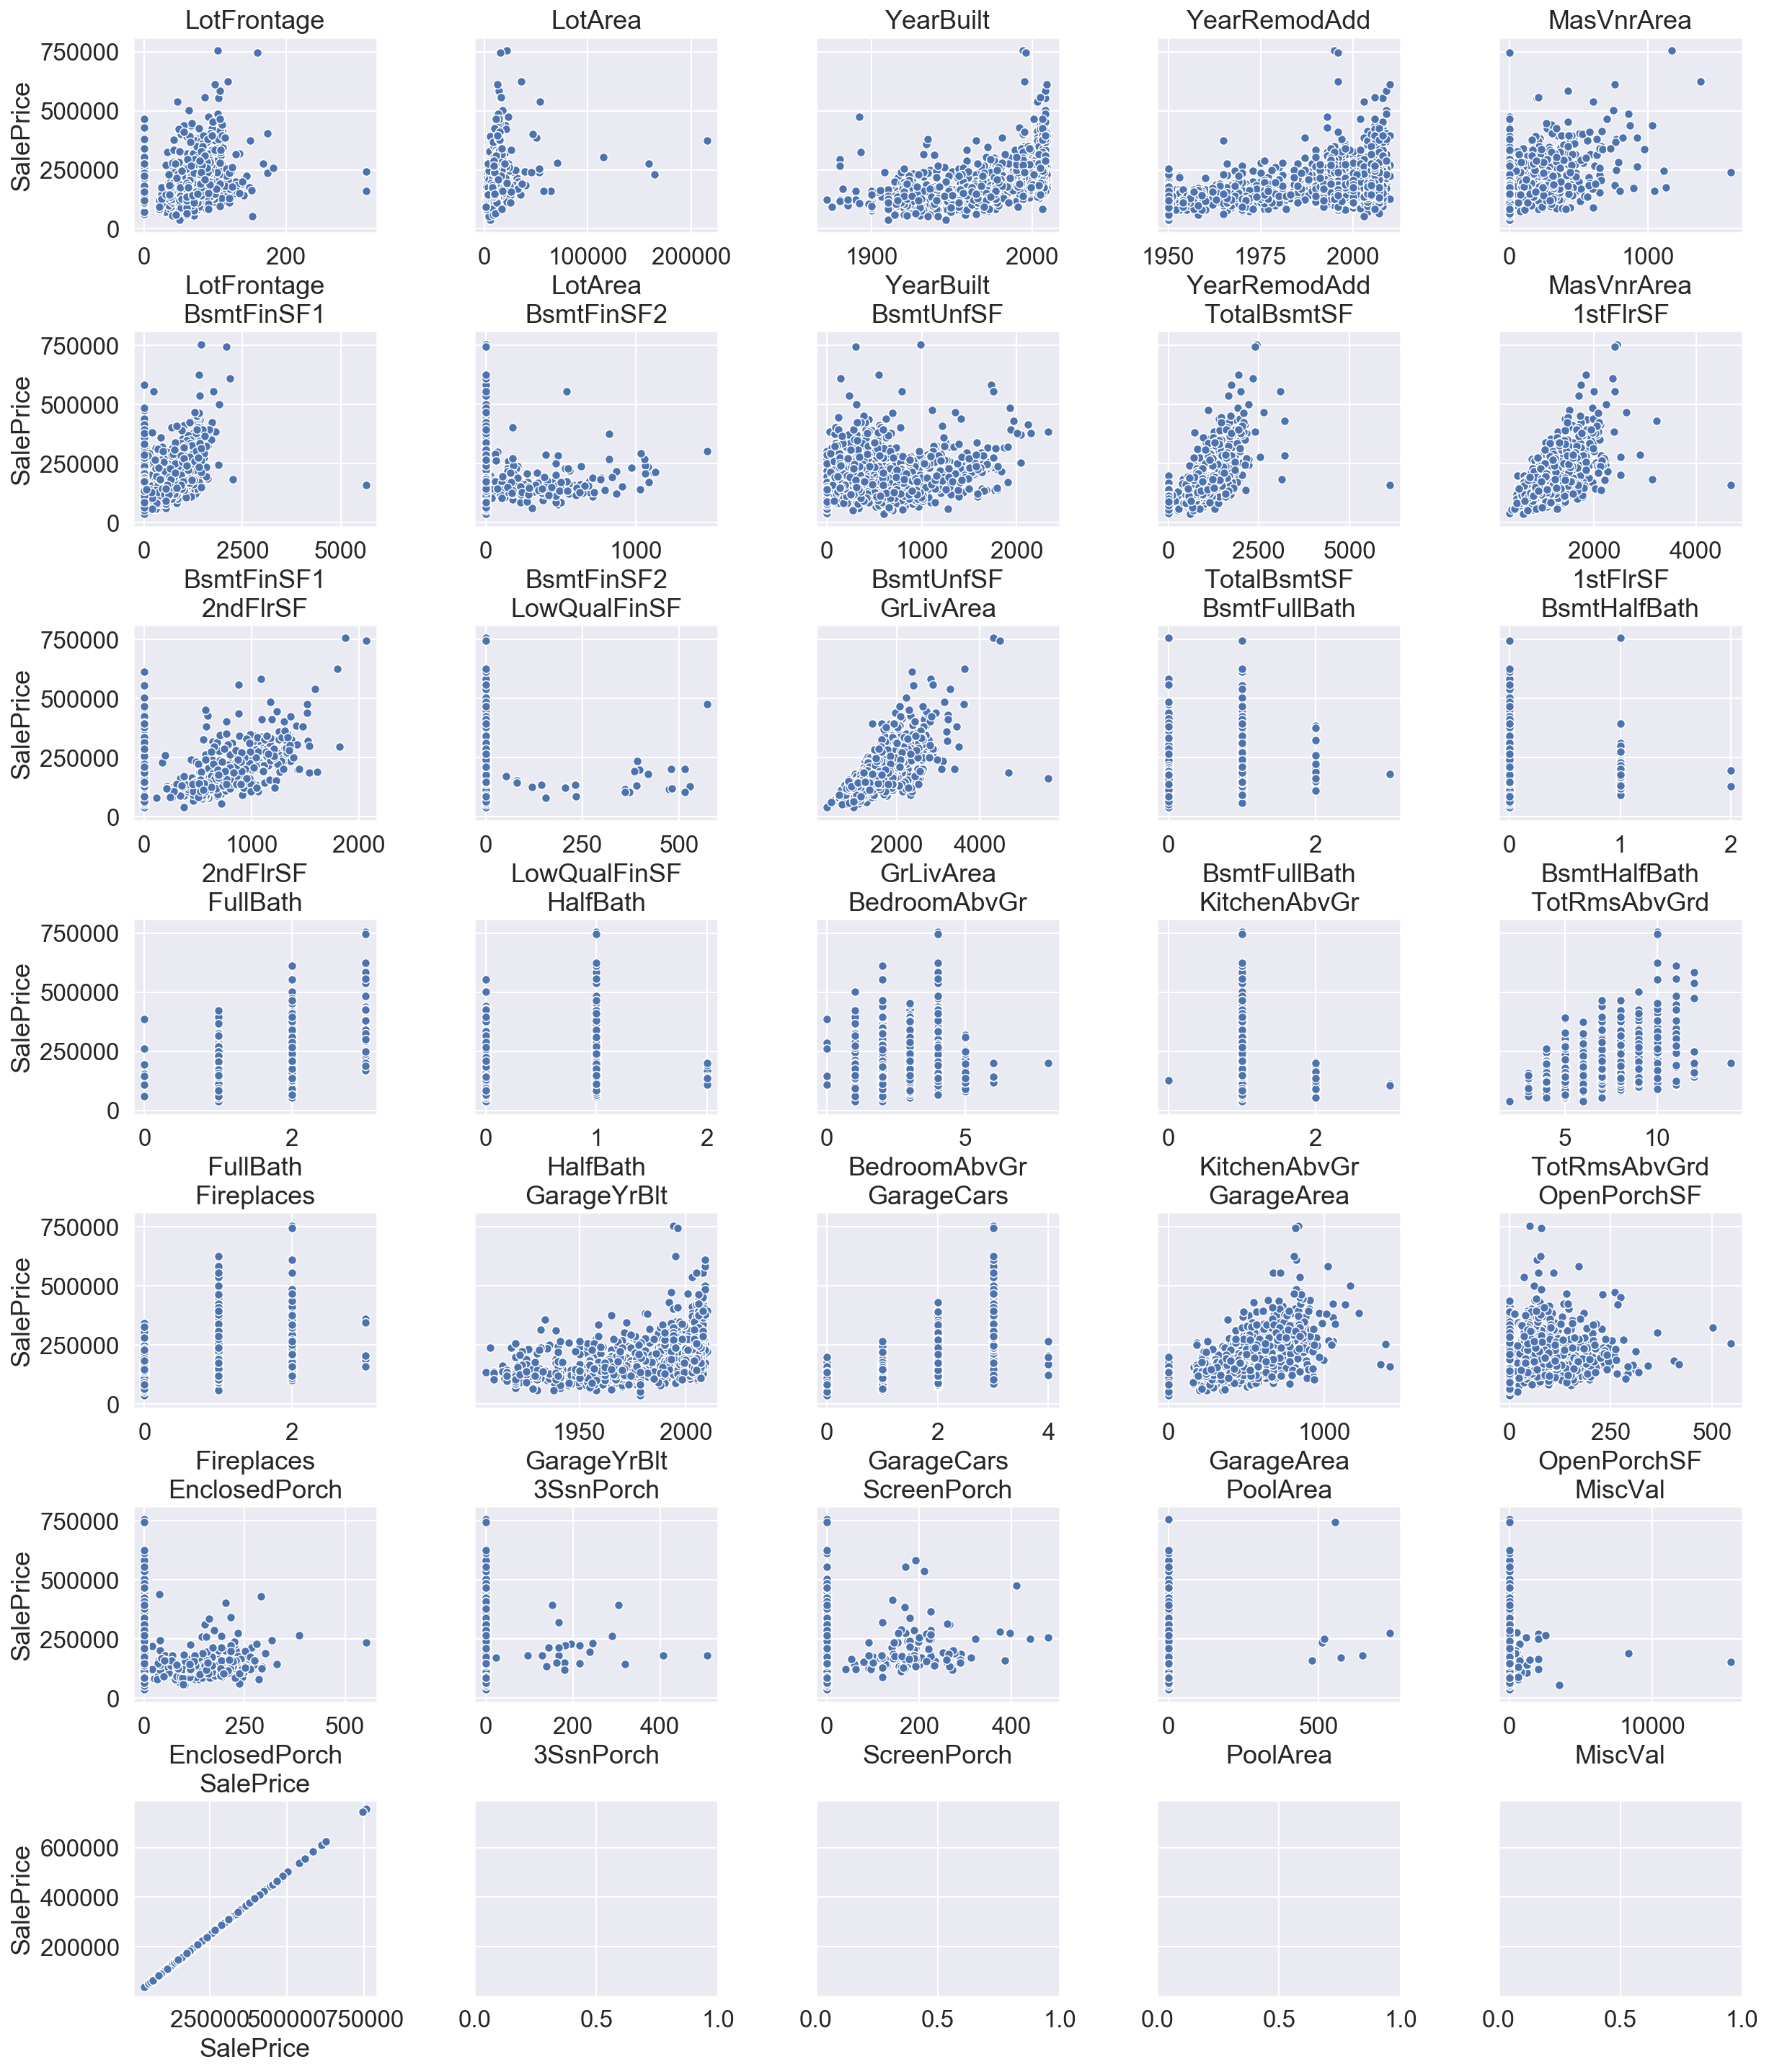

In [40]:
#Plot all the numeric variables against Sale price to detirmine any correlation for feature engineering
plt_cols=5
plt_rows=7 #int(np.ceil(len(numeric_list))/plt_cols)
fig, ax = plt.subplots(plt_rows,plt_cols,figsize=(20,25),sharey='row')
fig.subplots_adjust(hspace=.5, wspace=0.4)
count=0
for col in numeric_list:
    x,y = divmod(count,plt_cols)
    sns.scatterplot(x=col,y='SalePrice', data=house, ax=ax[x,y])
    ax[x,y].set_title(col)
#    ax[x,y].set.y_ticklabels(rotation=45)
    count+=1

plt.show()

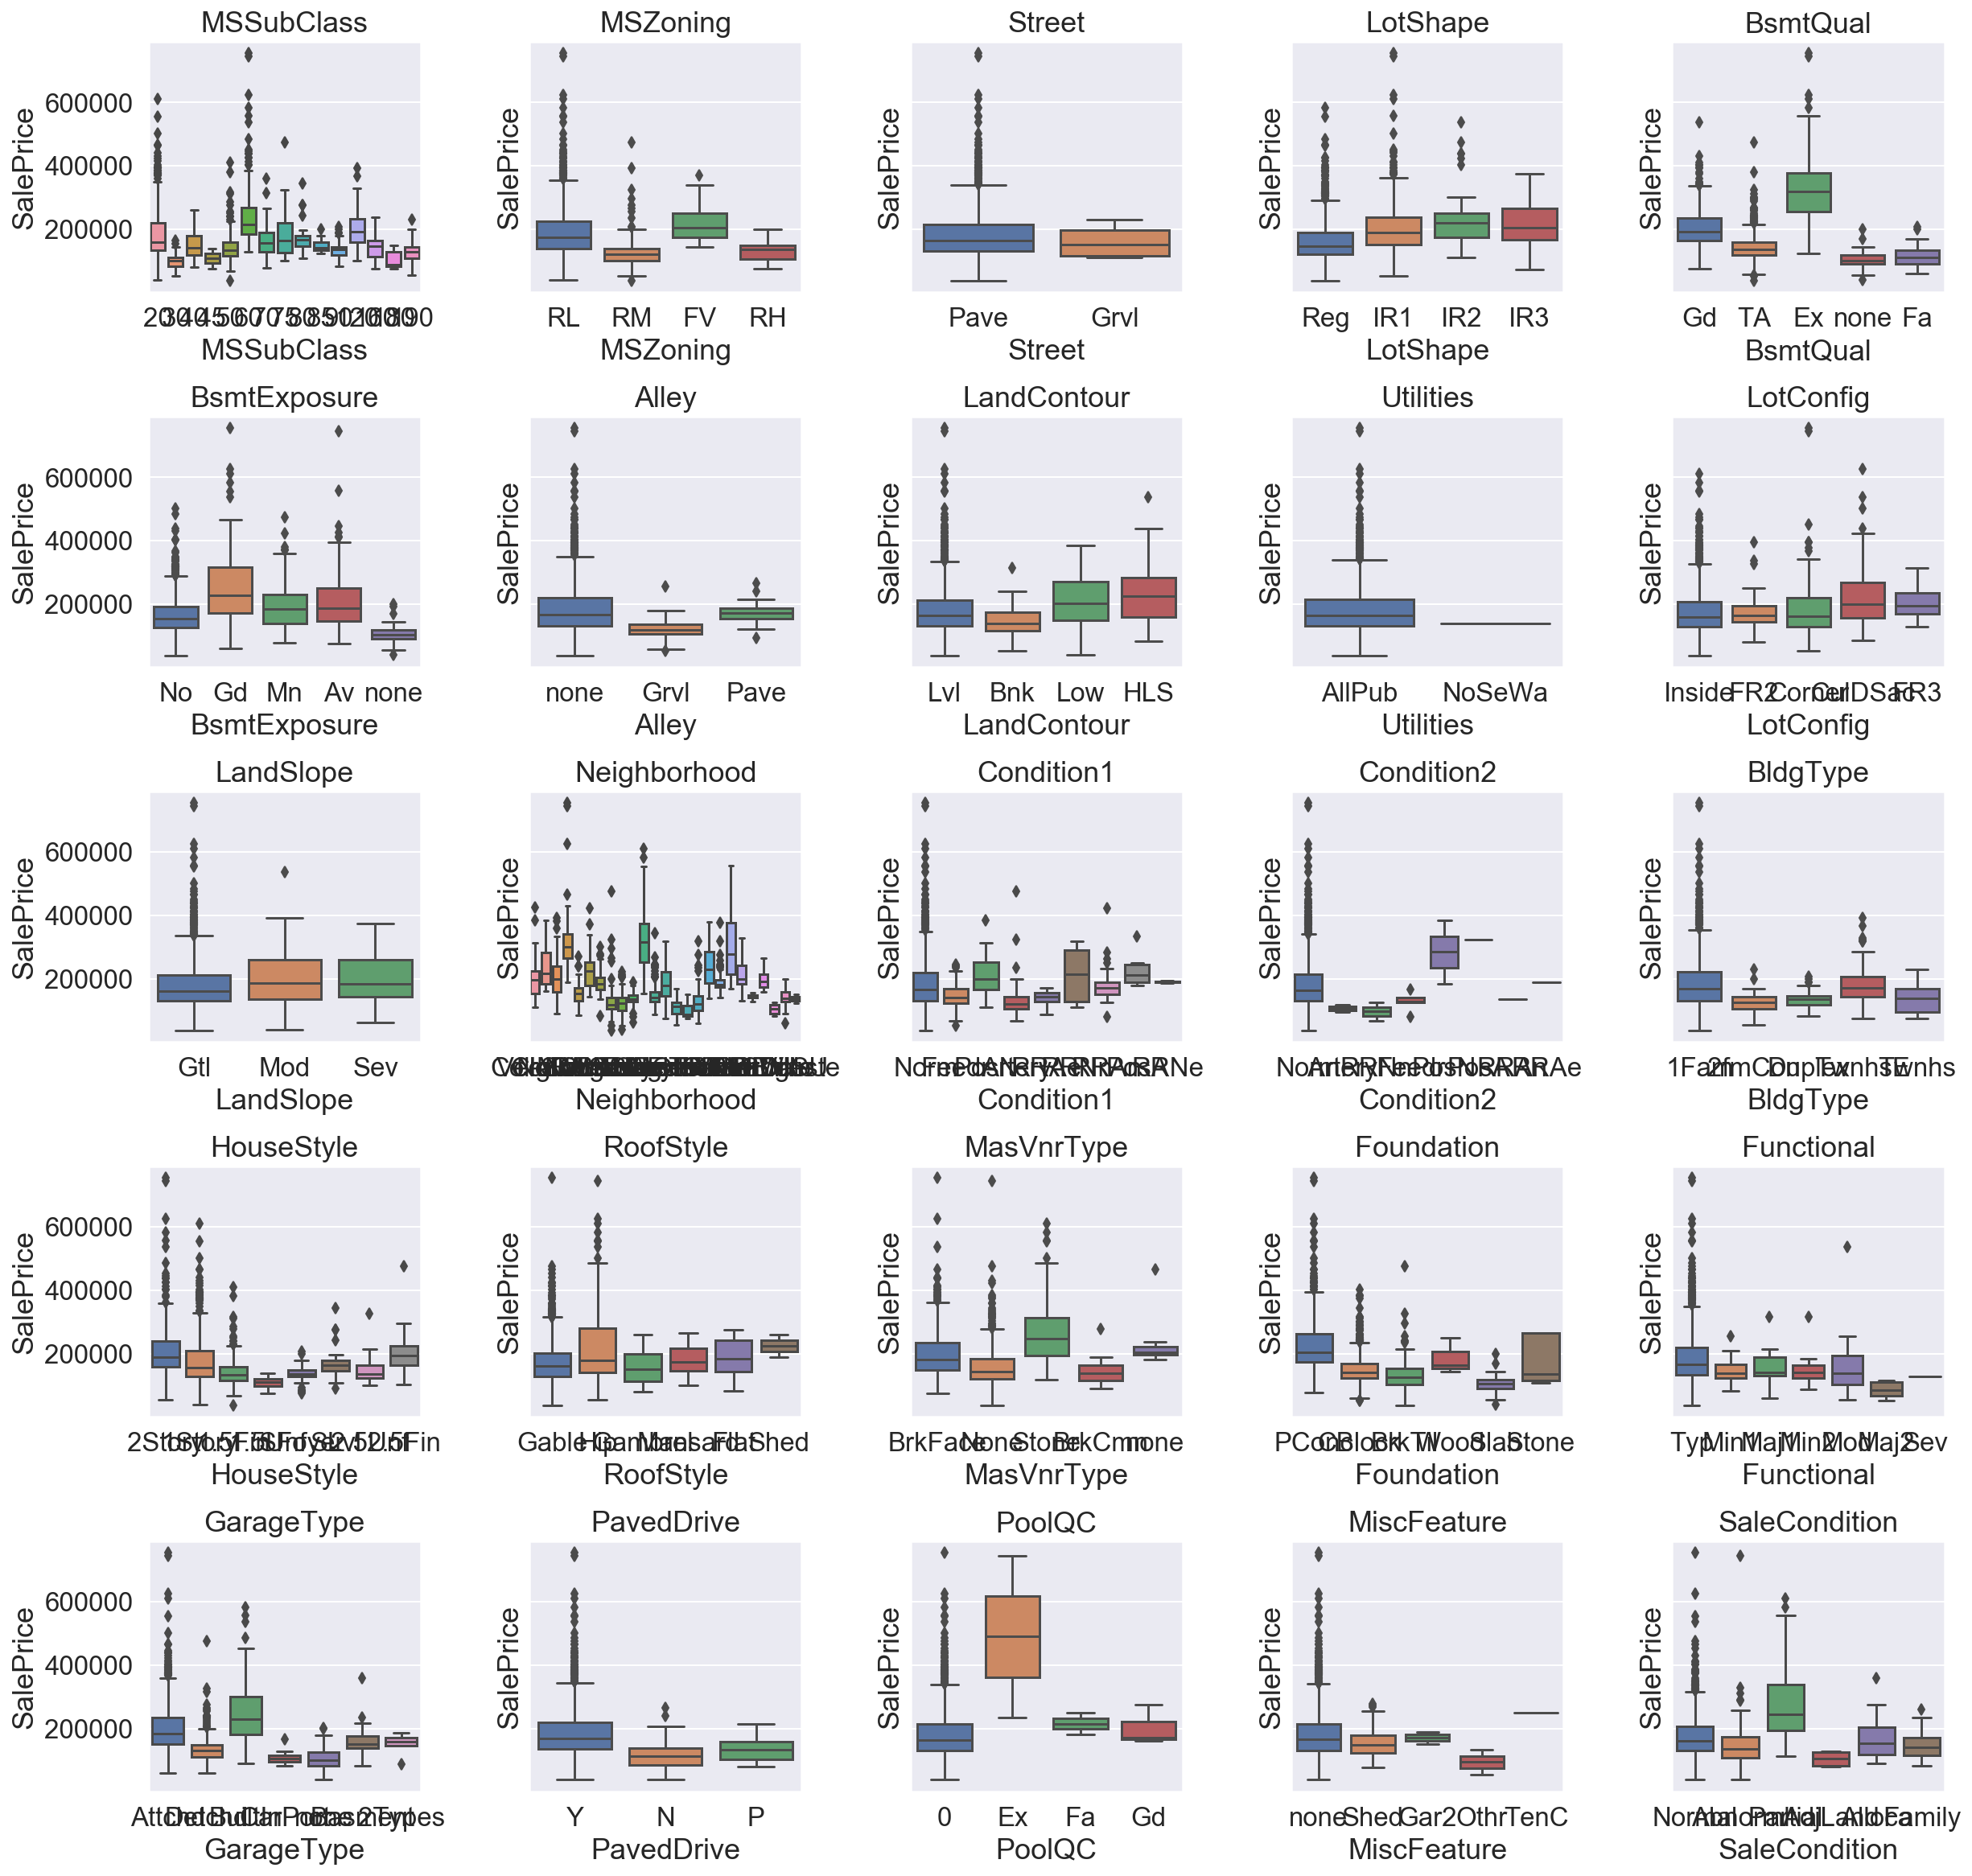

In [41]:
plt_cols=5
plt_rows=int(np.ceil(len(to_dummy)/plt_cols))
fig, ax = plt.subplots(plt_rows,plt_cols,figsize=(20,20),sharey='row')
count=0
fig.subplots_adjust(hspace=0.5, wspace=0.4)
for col in to_dummy:
    x,y = divmod(count,plt_cols)
    sns.boxplot(x=col,y='SalePrice', data=house_fixed,ax=ax[x,y])
    ax[x,y].set_title(col)
    count+=1

plt.show()

In [42]:
house_dum = pd.get_dummies(house_fixed, columns=to_dummy,drop_first=True)
house_dum.head()

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  YrSold  SalePrice  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Pave  LotShape_IR2  LotShape_IR3  LotShape_Reg  BsmtQual_Fa  BsmtQual_Gd  BsmtQual_TA  BsmtQual_none  BsmtExposure_Gd  BsmtExposure_Mn  BsmtExposure_No  BsmtExposure_none  Alley_Pave  Alley_none  LandContour_HLS  LandContour_Low  LandContour_Lvl  Utilities_NoSeWa  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Mod  \
0         65.0     8450       2003          2003       196.0         706           0        150          856       856       854             0       1710             1             0         2         1             3             1             8           0       2003.0           2         548           61              0          0            0         0        0    2008     208500              0              0              0              0              1              0              0              0              0              0               0               0               0               0            0            1            0            1             0             0             1            0            1            0              0                0                0                1                  0           0           1                0                0                1                 0                  0              0              0                 1              0   
1         80.0     9600       1976          1976         0.0         978           0        284         1262      1262         0             0       1262             0             1         2         0             3             1             6           1       1976.0           2         460            0              0          0            0         0        0    2007     181500              0              0              0              0              0              0              0              0              0              0               0               0               0               0            0            1            0            1             0             0             1            0            1            0              0                1                0                0                  0           0           1                0                0                1                 0                  0              1              0                 0              0   
2         68.0    11250       2001          2002       162.0         486           0        434          920       920       866             0       1786             1             0         2         1             3             1             6           1       2001.0           2         608           42              0          0            0         0        0    2008     223500              0              0              0              0              1              0              0              0              0              0               0               0               0               0            0            1            0            1             0             0             0            0            1            0              0                0                1                0                  0           0           1                0                0                1                 0                  0              0              0                 1              0   
3         60.0     9550       1

In [43]:
y_full = house_dum["SalePrice"]
X_full = house_dum.drop(columns=["SalePrice",'YrSold'])


In [44]:
#Create a training data subset based on all sales prior to 2010
y_train = house_dum[house_dum['YrSold']<2010].pop("SalePrice")
X_train = house_dum[house_dum['YrSold']<2010].drop(columns=["SalePrice",'YrSold'])

In [45]:
#Create a test Data subset based on 2010 sales
y_test = house_dum[house_dum['YrSold']==2010].pop("SalePrice")
X_test = house_dum[house_dum['YrSold']==2010].drop(columns=["SalePrice",'YrSold'])

In [46]:
# standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [47]:
X_full=pd.DataFrame(scaler.transform(X_full), columns=X_test.columns)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [48]:
X_test.head()

LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   MiscVal  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Pave  LotShape_IR2  LotShape_IR3  LotShape_Reg  BsmtQual_Fa  BsmtQual_Gd  BsmtQual_TA  BsmtQual_none  BsmtExposure_Gd  BsmtExposure_Mn  BsmtExposure_No  BsmtExposure_none  Alley_Pave  Alley_none  LandContour_HLS  LandContour_Low  LandContour_Lvl  Utilities_NoSeWa  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Mod  LandSlope_Sev  \
0    -1.652964  0.065384  -0.050764     -0.726932    0.403559    0.292619   -0.285219  -0.327427    -0.127222 -0.415089 -0.802656     -0.122492  -0.980712      1.128504     -0.251891 -1.040445 -0.764364     -1.063097     -0.205145     -0.938617    0.592492    -0.354984     0.29270    0.017565    -0.714470       -0.34839  -0.118545    -0.270088 -0.073474  1.293969       -0.22204      -0.048526      -0.097397      -0.332317      -0.514156      -0.210128      -0.112643      -0.201866      -0.112643      -0.191118       -0.251556       -0.212151       -0.084248       -0.138398    -0.112643     0.515373    -0.424525     0.048526      -0.16787     -0.088841     -1.292884    -0.160321    -0.861484     1.133330      -0.160321        -0.326475        -0.289898         0.731338          -0.162872   -0.172739     0.26535        -0.195477        -0.157733         0.343822         -0.027995           3.842581      -0.182131      -0.056055         -1.630652      -0.216151      -0.093214   
1    -1.652964 -0.222507  -0.116846      0.779247   -0.569789   -0.556142    4.003705  -0.824267    -0.000607 -0.270470 -0.802656     -0.122492  -0.874700      1.128504     -0.251891 -1.040445 -0.764364      0.162151     -0.205145     -0.322363    0.592492    -0.437785    -1.04222   -0.956283     0.630471       -0.34839  -0.118545    -0.270088 -0.073474 -0.075660       -0.22204      -0.048526      -0.097397      -0.332317      -0.514156      -0.210128      -0.112643      -0.201866      -0.112643      -0.191118       -0.251556       -0.212151       -0.084248       -0.138398    -0.112643     0.515373    -0.424525     0.048526      -0.16787     -0.088841     -1.292884    -0.160321    -0.861484     1.133330      -0.160321        -0.326475         3.449491        -1.367356          -0.162872   -0.172739     0.26535        -0.195477        -0.157733         0.343822         -0.027995          -0.260242      -0.182131      -0.056055          0.613252      -0.216151      -0.093214   
2     0.074585 -0.323053  -0.678538      0.730661   -0.569789   -0.456032    2.835166  -0.877979    -0.362362 -0.683666 -0.802656     -0.122492  -1.177590     -0.803265      3.768925 -1.040445 -0.764364      0.162151     -0.205145     -0.938617   -0.970757     1.094043     0.29270    0.462753    -0.236269       -0.34839  -0.118545    -0.270088 -0.073474 -0.075660       -0.22204      -0.048526      -0.097397      -0.332317      -0.514156      -0.210128      -0.112643      -0.201866      -0.112643      -0.191118       -0.251556       -0.212151       -0.084248       -0.138398    -0.112643     0.515373    -0.424525     0.048526      -0.16787     -0.088841      0.773465    -0.160321    -0.861484     1.133330      -0.160321        -0.326475         3.449491        -1.367356          -0.162872   -0.172739     0.26535        -0.195477        -0.157733         0.343822         -0.027995          -0.260242      -0.182131      -0.056055         -1.630652      -0.216151      -0.093214   
3     1.168700  0.088166   1.171742    

In [49]:
X_train.head()

LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Pave  LotShape_IR2  LotShape_IR3  LotShape_Reg  BsmtQual_Fa  BsmtQual_Gd  BsmtQual_TA  BsmtQual_none  BsmtExposure_Gd  BsmtExposure_Mn  BsmtExposure_No  BsmtExposure_none  Alley_Pave  Alley_none  LandContour_HLS  LandContour_Low  LandContour_Lvl  Utilities_NoSeWa  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Mod  LandSlope_Sev  \
0     0.218548 -0.202898   1.039579      0.876420    0.490079    0.571187   -0.285219  -0.945120    -0.461845 -0.797295  1.148308     -0.122492   0.355789      1.128504     -0.251891  0.777131  1.219565      0.162151     -0.205145      0.910145   -0.970757     1.011241     0.29270    0.332907     0.197101       -0.34839  -0.118545    -0.270088 -0.073474 -0.07566       -0.22204      -0.048526      -0.097397      -0.332317       1.944935      -0.210128      -0.112643      -0.201866      -0.112643      -0.191118       -0.251556       -0.212151       -0.084248       -0.138398    -0.112643     0.515373    -0.424525     0.048526      -0.16787     -0.088841      0.773465    -0.160321     1.160787    -0.882356      -0.160321        -0.326475        -0.289898         0.731338          -0.162872   -0.172739     0.26535        -0.195477        -0.157733         0.343822         -0.027995          -0.260242      -0.182131      -0.056055          0.613252      -0.216151      -0.093214   
1     0.650435 -0.092355   0.147480     -0.435413   -0.569789    1.163143   -0.285219  -0.645225     0.456108  0.251190 -0.802656     -0.122492  -0.492302     -0.803265      3.768925  0.777131 -0.764364      0.162151     -0.205145     -0.322363    0.592492    -0.106579     0.29270   -0.075182    -0.714470       -0.34839  -0.118545    -0.270088 -0.073474 -0.07566       -0.22204      -0.048526      -0.097397      -0.332317      -0.514156      -0.210128      -0.112643      -0.201866      -0.112643      -0.191118       -0.251556       -0.212151       -0.084248       -0.138398    -0.112643     0.515373    -0.424525     0.048526      -0.16787     -0.088841      0.773465    -0.160321     1.160787    -0.882356      -0.160321         3.063024        -0.289898        -1.367356          -0.162872   -0.172739     0.26535        -0.195477        -0.157733         0.343822         -0.027995          -0.260242       5.490568      -0.056055         -1.630652      -0.216151      -0.093214   
2     0.304925  0.066249   0.973498      0.827833    0.306224    0.092399   -0.285219  -0.309523    -0.317143 -0.632017  1.175722     -0.122492   0.499661      1.128504     -0.251891  0.777131  1.219565      0.162151     -0.205145     -0.322363    0.592492     0.928440     0.29270    0.611149    -0.086831       -0.34839  -0.118545    -0.270088 -0.073474 -0.07566       -0.22204      -0.048526      -0.097397      -0.332317       1.944935      -0.210128      -0.112643      -0.201866      -0.112643      -0.191118       -0.251556       -0.212151       -0.084248       -0.138398    -0.112643     0.515373    -0.424525     0.048526      -0.16787     -0.088841     -1.292884    -0.160321     1.160787    -0.882356      -0.160321        -0.326475         3.449491        -1.367356          -0.162872   -0.172739     0.26535        -0.195477        -0.157733         0.343822         -0.027995          -0.260242      -0.182131      -0.056055          0.613252      -0.216151      -0.093214   
3     0.074585 -0.097161  -1.868003     -0.

In [50]:
#set up a dictionary to store the results from each regression model in
results_dict={}

In [51]:
# create a linear regression model instance
lr_model = LinearRegression()

# get cross validated scores
scores = cross_val_score(lr_model, X_train, y_train, cv=10)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
lr_model.fit(X_train, y_train)
print("Training Score:", lr_model.score(X_train, y_train))

results_dict['linear_regression']={'cross_val_score':scores, 
                              "Mean cross-validated training score": scores.mean(),
                             'Training score':lr_model.score(X_train, y_train)}

Cross-validated training scores: [ 8.73671295e-01  8.09619705e-01 -9.56782164e+20 -8.53437310e+18
 -6.09054132e+13 -2.55004849e+23 -7.56364131e+21  8.57665025e-01
 -5.61620489e+21 -1.64347579e+04]
Mean cross-validated training score: -2.691500116916835e+22
Training Score: 0.8961040495052202


In [52]:
# create a RidgeCV model instance
RCV_model = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=10)
# fit the model
RCV_model.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', RCV_model.alpha_)
# evaluate on the training set
print('Training score:', RCV_model.score(X_train, y_train))
results_dict['RidgeCV']={'Best alpha': RCV_model.alpha_,
                             'Training score':RCV_model.score(X_train, y_train)}

Best alpha: 1291.5496650148827
Training score: 0.8273449377938693


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [53]:
# create a Ridge model instance
R_model = Ridge(alpha=RCV_model.alpha_)

# get cross validated scores
R_scores = cross_val_score(R_model, X_train, y_train, cv=10)
print("Cross-validated training scores:", R_scores)
print("Mean cross-validated training score:", R_scores.mean())
# fit and evaluate the data on the whole training set
R_model.fit(X_train, y_train)
print("Training Score:", R_model.score(X_train, y_train))
results_dict['Ridge']={'cross_val_score':R_scores, 
                              "Mean cross-validated training score": R_scores.mean(),
                             'Training score':R_model.score(X_train, y_train)}

Cross-validated training scores: [0.87412182 0.78597657 0.84726692 0.73531137 0.76665221 0.80675064
 0.86870154 0.83282925 0.54271917 0.82561486]
Mean cross-validated training score: 0.7885944346935216
Training Score: 0.8273449377938693


In [54]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(R_model.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef[df_coef['coef_abs']>0].sort_values(by='coef_abs',ascending=False)

coefficients     coef_abs
GrLivArea               7468.647883  7468.647883
1stFlrSF                5961.210804  5961.210804
Neighborhood_NridgHt    5734.649246  5734.649246
Neighborhood_NoRidge    5105.448201  5105.448201
TotalBsmtSF             4988.921326  4988.921326
TotRmsAbvGrd            4856.692603  4856.692603
GarageCars              4819.334138  4819.334138
Fireplaces              4491.572918  4491.572918
GarageArea              4371.863120  4371.863120
YearRemodAdd            4363.519293  4363.519293
FullBath                4192.360508  4192.360508
MasVnrArea              3945.999137  3945.999137
Neighborhood_StoneBr    3906.716337  3906.716337
BsmtExposure_Gd         3782.242846  3782.242846
2ndFlrSF                3740.955105  3740.955105
BsmtFinSF1              3637.117839  3637.117839
BsmtQual_TA            -3263.146154  3263.146154
PoolQC_Ex               3231.537414  3231.537414
SaleCondition_Partial   3152.130217  3152.130217
BsmtExposure_No        -3026.643244  3026.643244
PoolQC_Gd              -2550.654676  2550.654676
YearBuilt               2538.603532  2538.603532
LotArea                 2523.542951  2523.542951
Neighborhood_Edwards   -2502.504046  2502.504046
BsmtFullBath            2467.897019  2467.897019
Foundation_PConc        2332.775021  2332.775021
Neighborhood_NAmes     -2228.683628  2228.683628
HalfBath                2176.676222  2176.676222
BsmtQual_Gd            -2163.056874  2163.056874
Neighborhood_Crawfor    2098.628224  2098.628224
KitchenAbvGr           -2096.538454  2096.538454
MasVnrType_Stone        2091.519451  2091.519451
OpenPorchSF             2073.308753  2073.308753
GarageYrBlt             2064.637023  2064.637023
GarageType_BuiltIn      2047.409610  2047.409610
Condition2_PosN        -2020.302777  2020.302777
RoofStyle_Gable        -1926.813897  1926.813897
Foundation_CBlock      -1913.534528  1913.534528
Neighborhood_Gilbert   -1901.217743  1901.217743
Functional_Typ          1834.845455  1834.845455
RoofStyle_Hip           1805.594126  1805.594126
ScreenPorch             1701.458875  1701.458875
LotConfig_CulDSac       1644.191063  1644.191063
MSSubClass_160         -1611.584319  1611.584319
Condition1_Norm         1598.230712  1598.230712
Neighborhood_Somerst    1588.536780  1588.536780
Neighborhood_Mitchel   -1548.708110  1548.708110
Condition1_Feedr       -1483.448154  1483.448154
MSSubClass_60           1448.674691  1448.674691
MSZoning_RM            -1420.273222  1420.273222
Neighborhood_Veenker    1396.874196  1396.874196
Condition2_PosA         1376.966440  1376.966440
GarageType_Detchd      -1375.010791  1375.010791
LotShape_IR3           -1342.527995  1342.527995
MSSubClass_90          -1334.119890  1334.119890
BldgType_Duplex        -1334.119890  1334.119890
LotShape_IR2            1325.864518  1325.864518
LotShape_Reg           -1244.450588  1244.450588
BldgType_Twnhs         -1209.130735  1209.130735
Neighborhood_Sawyer    -1208.043273  1208.043273
LandContour_HLS         1156.383792  1156.383792
Neighborhood_NWAmes    -1142.781688  1142.781688
BldgType_TwnhsE        -1098.029986  1098.029986
LotFrontage             1061.289500  1061.289500
Functional_Sev         -1022.820249  1022.820249
BsmtUnfSF               1017.020117  1017.020117
MSSubClass_30           -959.777712   959.777712
LotConfig_FR2           -954.578915   954.578915
Functional_Maj2         -928.998875   928.998875
Neighborhood_CollgCr    -927.246178   927.246178
BsmtQual_Fa             -927.037299   927.037299
SaleCondition_Family    -924.736499   924.736499
Neighborhood_MeadowV    -918.520713   918.520713
PavedDrive_Y             893.936673   893.936673
GarageType_Attchd        878.077713   878.077713
Functional_Min2         -847.132113   847.132113
Neighborhood_OldTown    -841.935702   841.935702
PoolArea                 833.961099   833.961099
BsmtExposure_none       -803.254155   803.254155
Condition1_RRAe         -767.329855   767.329855
BsmtQual_none           -721.397032   721.397032
Condi

In [55]:
df_coef[df_coef['coef_abs']>0].sort_values(by='coef_abs',ascending=False)

coefficients     coef_abs
GrLivArea               7468.647883  7468.647883
1stFlrSF                5961.210804  5961.210804
Neighborhood_NridgHt    5734.649246  5734.649246
Neighborhood_NoRidge    5105.448201  5105.448201
TotalBsmtSF             4988.921326  4988.921326
TotRmsAbvGrd            4856.692603  4856.692603
GarageCars              4819.334138  4819.334138
Fireplaces              4491.572918  4491.572918
GarageArea              4371.863120  4371.863120
YearRemodAdd            4363.519293  4363.519293
FullBath                4192.360508  4192.360508
MasVnrArea              3945.999137  3945.999137
Neighborhood_StoneBr    3906.716337  3906.716337
BsmtExposure_Gd         3782.242846  3782.242846
2ndFlrSF                3740.955105  3740.955105
BsmtFinSF1              3637.117839  3637.117839
BsmtQual_TA            -3263.146154  3263.146154
PoolQC_Ex               3231.537414  3231.537414
SaleCondition_Partial   3152.130217  3152.130217
BsmtExposure_No        -3026.643244  3026.643244
PoolQC_Gd              -2550.654676  2550.654676
YearBuilt               2538.603532  2538.603532
LotArea                 2523.542951  2523.542951
Neighborhood_Edwards   -2502.504046  2502.504046
BsmtFullBath            2467.897019  2467.897019
Foundation_PConc        2332.775021  2332.775021
Neighborhood_NAmes     -2228.683628  2228.683628
HalfBath                2176.676222  2176.676222
BsmtQual_Gd            -2163.056874  2163.056874
Neighborhood_Crawfor    2098.628224  2098.628224
KitchenAbvGr           -2096.538454  2096.538454
MasVnrType_Stone        2091.519451  2091.519451
OpenPorchSF             2073.308753  2073.308753
GarageYrBlt             2064.637023  2064.637023
GarageType_BuiltIn      2047.409610  2047.409610
Condition2_PosN        -2020.302777  2020.302777
RoofStyle_Gable        -1926.813897  1926.813897
Foundation_CBlock      -1913.534528  1913.534528
Neighborhood_Gilbert   -1901.217743  1901.217743
Functional_Typ          1834.845455  1834.845455
RoofStyle_Hip           1805.594126  1805.594126
ScreenPorch             1701.458875  1701.458875
LotConfig_CulDSac       1644.191063  1644.191063
MSSubClass_160         -1611.584319  1611.584319
Condition1_Norm         1598.230712  1598.230712
Neighborhood_Somerst    1588.536780  1588.536780
Neighborhood_Mitchel   -1548.708110  1548.708110
Condition1_Feedr       -1483.448154  1483.448154
MSSubClass_60           1448.674691  1448.674691
MSZoning_RM            -1420.273222  1420.273222
Neighborhood_Veenker    1396.874196  1396.874196
Condition2_PosA         1376.966440  1376.966440
GarageType_Detchd      -1375.010791  1375.010791
LotShape_IR3           -1342.527995  1342.527995
MSSubClass_90          -1334.119890  1334.119890
BldgType_Duplex        -1334.119890  1334.119890
LotShape_IR2            1325.864518  1325.864518
LotShape_Reg           -1244.450588  1244.450588
BldgType_Twnhs         -1209.130735  1209.130735
Neighborhood_Sawyer    -1208.043273  1208.043273
LandContour_HLS         1156.383792  1156.383792
Neighborhood_NWAmes    -1142.781688  1142.781688
BldgType_TwnhsE        -1098.029986  1098.029986
LotFrontage             1061.289500  1061.289500
Functional_Sev         -1022.820249  1022.820249
BsmtUnfSF               1017.020117  1017.020117
MSSubClass_30           -959.777712   959.777712
LotConfig_FR2           -954.578915   954.578915
Functional_Maj2         -928.998875   928.998875
Neighborhood_CollgCr    -927.246178   927.246178
BsmtQual_Fa             -927.037299   927.037299
SaleCondition_Family    -924.736499   924.736499
Neighborhood_MeadowV    -918.520713   918.520713
PavedDrive_Y             893.936673   893.936673
GarageType_Attchd        878.077713   878.077713
Functional_Min2         -847.132113   847.132113
Neighborhood_OldTown    -841.935702   841.935702
PoolArea                 833.961099   833.961099
BsmtExposure_none       -803.254155   803.254155
Condition1_RRAe         -767.329855   767.329855
BsmtQual_none           -721.397032   721.397032
Condi

In [56]:
# create a LassoCV model instance
LCV_model = LassoCV(n_alphas=1000, cv=10)
# fit the model
LCV_model.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', LCV_model.alpha_)
# evaluate on the training set
print('Training score:', LCV_model.score(X_train, y_train))
results_dict['LassoCV']={'Best alpha': LCV_model.alpha_,
                             'Training score':LCV_model.score(X_train, y_train)}

Best alpha: 1320.3021186791618
Training score: 0.8530042145114979


In [57]:
# create a Lasso model instance
L_model = Lasso(alpha=LCV_model.alpha_)

# get cross validated scores
L_scores = cross_val_score(L_model, X_train, y_train, cv=10)
print("Cross-validated training scores:", L_scores)
print("Mean cross-validated training score:", L_scores.mean())
# fit and evaluate the data on the whole training set
L_model.fit(X_train, y_train)
print("Training Score:", L_model.score(X_train, y_train))
results_dict['Lasso']={'cross_val_score':L_scores, 
                              "Mean cross-validated training score": L_scores.mean(),
                             'Training score':L_model.score(X_train, y_train)}

Cross-validated training scores: [0.88868303 0.79410041 0.87615857 0.7422481  0.82382255 0.73645863
 0.88013508 0.83094429 0.48332511 0.76707542]
Mean cross-validated training score: 0.7822951186355469
Training Score: 0.8530042145114979


In [58]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(L_model.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef

coefficients      coef_abs
LotFrontage               -0.000000      0.000000
LotArea                 1736.605974   1736.605974
YearBuilt               7764.464606   7764.464606
YearRemodAdd            7431.975236   7431.975236
MasVnrArea              2187.011503   2187.011503
BsmtFinSF1              3081.563946   3081.563946
BsmtFinSF2                 0.000000      0.000000
BsmtUnfSF                 -0.000000      0.000000
TotalBsmtSF             7300.255337   7300.255337
1stFlrSF                 256.968469    256.968469
2ndFlrSF                   0.000000      0.000000
LowQualFinSF              -7.514915      7.514915
GrLivArea              29636.853309  29636.853309
BsmtFullBath            2385.335378   2385.335378
BsmtHalfBath               0.000000      0.000000
FullBath                1898.139159   1898.139159
HalfBath                   0.000000      0.000000
BedroomAbvGr            -888.694610    888.694610
KitchenAbvGr           -5096.424464   5096.424464
TotRmsAbvGrd            1029.982606   1029.982606
Fireplaces              4278.033455   4278.033455
GarageYrBlt                0.000000      0.000000
GarageCars              8756.483763   8756.483763
GarageArea                 0.000000      0.000000
OpenPorchSF              293.519875    293.519875
EnclosedPorch             -0.000000      0.000000
3SsnPorch                  0.000000      0.000000
ScreenPorch             1458.702177   1458.702177
PoolArea                   0.000000      0.000000
MiscVal                   -0.000000      0.000000
MSSubClass_30              0.000000      0.000000
MSSubClass_40             -0.000000      0.000000
MSSubClass_45              0.000000      0.000000
MSSubClass_50             -0.000000      0.000000
MSSubClass_60              0.000000      0.000000
MSSubClass_70              0.000000      0.000000
MSSubClass_75             -0.000000      0.000000
MSSubClass_80              0.000000      0.000000
MSSubClass_85             -0.000000      0.000000
MSSubClass_90          -1504.168601   1504.168601
MSSubClass_120            -0.000000      0.000000
MSSubClass_160         -1501.544661   1501.544661
MSSubClass_180            -0.000000      0.000000
MSSubClass_190            -0.000000      0.000000
MSZoning_RH               -0.000000      0.000000
MSZoning_RL                0.000000      0.000000
MSZoning_RM             -676.777005    676.777005
Street_Pave                0.000000      0.000000
LotShape_IR2             945.946216    945.946216
LotShape_IR3           -1527.457357   1527.457357
LotShape_Reg              -0.000000      0.000000
BsmtQual_Fa             -484.074812    484.074812
BsmtQual_Gd            -5724.549033   5724.549033
BsmtQual_TA            -4934.313419   4934.313419
BsmtQual_none             -0.000000      0.000000
BsmtExposure_Gd         4992.113487   4992.113487
BsmtExposure_Mn           -0.000000      0.000000
BsmtExposure_No        -2887.511811   2887.511811
BsmtExposure_none       -121.793289    121.793289
Alley_Pave                -0.000000      0.000000
Alley_none                 4.972731      4.972731
LandContour_HLS          289.402467    289.402467
LandContour_Low           -0.000000      0.000000
LandContour_Lvl            0.000000      0.000000
Utilities_NoSeWa          -0.000000      0.000000
LotConfig_CulDSac       1673.492334   1673.492334
LotConfig_FR2           -224.671468    224.671468
LotConfig_FR3             -0.000000      0.000000
LotConfig_Inside           0.000000      0.000000
LandSlope_Mod              0.000000      0.000000
LandSlope_Sev             -0.000000      0.000000
Neighborhood_Blueste       0.000000      0.000000
Neighborhood_BrDale        0.000000      0.000000
Neighborhood_BrkSide     448.500863    448.500863
Neighborhood_ClearCr      -0.000000      0.000000
Neighborhood_CollgCr       0.000000      0.000000
Neighborhood_Crawfor    3635.969507   3635.969507
Neighborhood_Edwards   -1851.071111   1851.071111
Neighborhood_Gilbert      -0.000000      0.000000
Neighborhood_IDOTRR    

In [59]:
L_coefs_abs=df_coef[df_coef['coef_abs']!=0].sort_values(by='coef_abs',ascending=False)

In [60]:
L_coefs_gr_zero=L_coefs_abs[['coefficients']].T.columns
L_coefs_gr_zero

Index(['GrLivArea', 'Neighborhood_NridgHt', 'GarageCars', 'Neighborhood_NoRidge', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'Neighborhood_StoneBr', 'BsmtQual_Gd', 'KitchenAbvGr', 'BsmtExposure_Gd', 'BsmtQual_TA', 'Functional_Typ', 'PoolQC_Gd', 'Condition2_PosN', 'Fireplaces', 'SaleCondition_Partial', 'Neighborhood_Somerst', 'Neighborhood_Crawfor', 'PoolQC_Ex', 'BsmtFinSF1', 'BsmtExposure_No', 'BldgType_TwnhsE', 'BsmtFullBath', 'MasVnrArea', 'RoofStyle_Gable', 'BldgType_Twnhs', 'FullBath', 'Neighborhood_Edwards', 'Condition1_Norm', 'LotArea', 'LotConfig_CulDSac', 'Neighborhood_Veenker', 'LotShape_IR3', 'MSSubClass_90', 'MSSubClass_160', 'ScreenPorch', 'Condition2_PosA', 'Condition1_Feedr', 'TotRmsAbvGrd', 'LotShape_IR2', 'BedroomAbvGr', 'Functional_Sev', 'Foundation_PConc', 'MSZoning_RM', 'Neighborhood_Mitchel', 'BsmtQual_Fa', 'Neighborhood_BrkSide', 'MasVnrType_Stone', 'BldgType_Duplex', 'OpenPorchSF', 'LandContour_HLS', '1stFlrSF', 'LotConfig_FR2', 'BsmtExposure_none',
       'SaleC

In [61]:
# create a Elastic Net CV model instance
E_model = ElasticNetCV(l1_ratio=np.linspace(0.9994,1,30), 
                     n_alphas=200,cv=10)
# fit the model
E_model.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', E_model.alpha_)
print('Best L1:', E_model.l1_ratio_)
# evaluate on the training set
print('Training score:', E_model.score(X_train, y_train))
results_dict['elastic_net_CV']={'Best alpha': E_model.alpha_,
                             'Training score':E_model.score(X_train, y_train),
                        'Best L1': E_model.l1_ratio_}

Best alpha: 840.2084757836788
Best L1: 0.9995241379310345
Training score: 0.8412080875019328


In [62]:
el_mod=ElasticNet(alpha=E_model.alpha_,l1_ratio=E_model.l1_ratio_)

el_scores = cross_val_score(el_mod, X_train, y_train, cv=10)
print("Cross-validated training scores:", el_scores)
print("Mean cross-validated training score:", el_scores.mean())
# fit and evaluate the data on the whole training set
el_mod.fit(X_train, y_train)
print("Training Score:", el_mod.score(X_train, y_train))

results_dict['elastic_net']={'cross_val_score':el_scores, 
                              "Mean cross-validated training score": el_scores.mean(),
                             'Training score':el_mod.score(X_train, y_train)}

Cross-validated training scores: [0.88514065 0.80197218 0.8666887  0.7526641  0.79885197 0.81001086
 0.88216177 0.83452247 0.52454192 0.81892705]
Mean cross-validated training score: 0.7975481689326759
Training Score: 0.8412080875019328


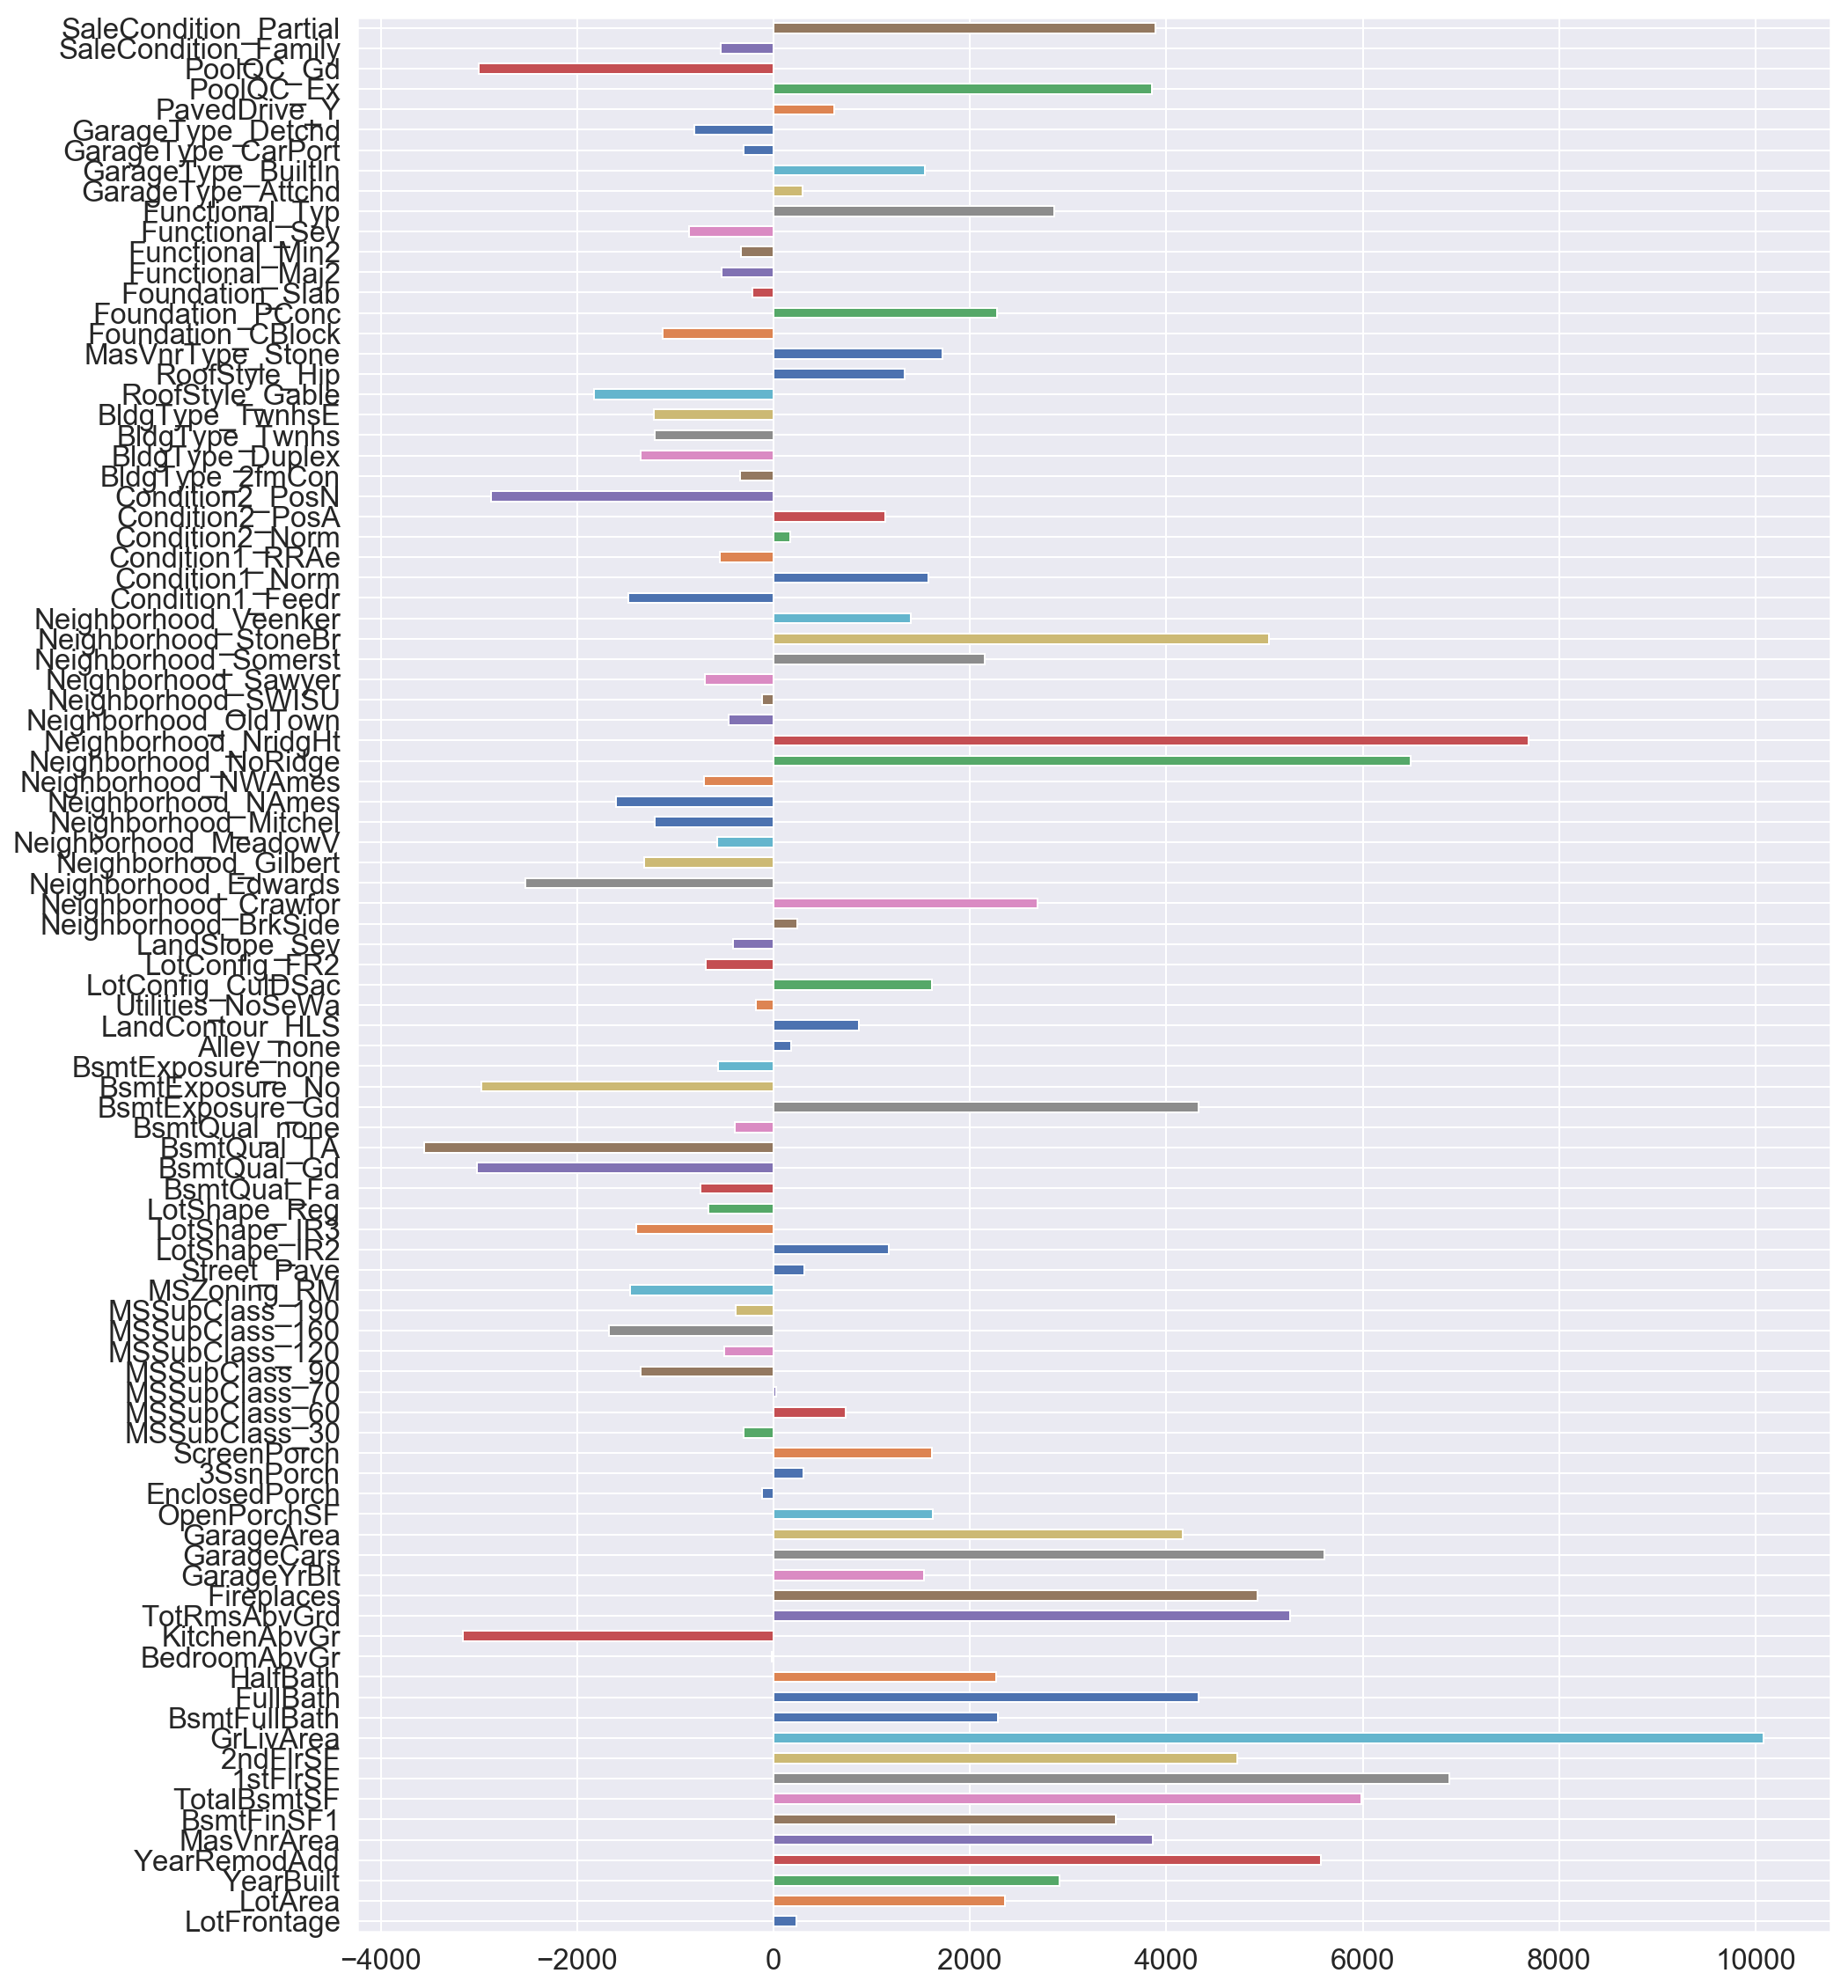

In [63]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(el_mod.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by='coef_abs')
fig, ax = plt.subplots(figsize=(15,20))
ax = df_coef[df_coef['coef_abs']!=0]['coefficients'].plot(kind='barh', ax=ax);

In [64]:
#Retry LR model with Lasso coefficients that haven't been zeroed out
X_test_2=X_test[L_coefs_gr_zero]
X_train_2=X_train[L_coefs_gr_zero]

In [65]:
LR2_model=LinearRegression()
# get cross validated scores
LR2_scores = cross_val_score(LR2_model, X_train, y_train, cv=10)
print("Cross-validated training scores:", LR2_scores)
print("Mean cross-validated training score:", LR2_scores.mean())
# fit and evaluate the data on the whole training set
LR2_model.fit(X_train, y_train)
print("Training Score:", LR2_model.score(X_train, y_train))

results_dict['liniar_regression_2']={'cross_val_score':LR2_scores, 
                              "Mean cross-validated training score": LR2_scores.mean(),
                             'Training score':LR2_model.score(X_train, y_train)}

Cross-validated training scores: [ 8.73671295e-01  8.09619705e-01 -9.56782164e+20 -8.53437310e+18
 -6.09054132e+13 -2.55004849e+23 -7.56364131e+21  8.57665025e-01
 -5.61620489e+21 -1.64347579e+04]
Mean cross-validated training score: -2.691500116916835e+22
Training Score: 0.8961040495052202


In [66]:
#Mean Cross validated score is still higher for the Elastic Net Model with all variables included, 
#so this is the appropriate model to use.

In [67]:
for key,values in results_dict.items():
    print('===============')
    print (key)
    print('===============')
    for i,x in values.items():
        print(i ,': \t ',x)
    print()

linear_regression
cross_val_score : 	  [ 8.73671295e-01  8.09619705e-01 -9.56782164e+20 -8.53437310e+18
 -6.09054132e+13 -2.55004849e+23 -7.56364131e+21  8.57665025e-01
 -5.61620489e+21 -1.64347579e+04]
Mean cross-validated training score : 	  -2.691500116916835e+22
Training score : 	  0.8961040495052202

RidgeCV
Best alpha : 	  1291.5496650148827
Training score : 	  0.8273449377938693

Ridge
cross_val_score : 	  [0.87412182 0.78597657 0.84726692 0.73531137 0.76665221 0.80675064
 0.86870154 0.83282925 0.54271917 0.82561486]
Mean cross-validated training score : 	  0.7885944346935216
Training score : 	  0.8273449377938693

LassoCV
Best alpha : 	  1320.3021186791618
Training score : 	  0.8530042145114979

Lasso
cross_val_score : 	  [0.88868303 0.79410041 0.87615857 0.7422481  0.82382255 0.73645863
 0.88013508 0.83094429 0.48332511 0.76707542]
Mean cross-validated training score : 	  0.7822951186355469
Training score : 	  0.8530042145114979

elastic_net_CV
Best alpha : 	  840.208475783678

The Elastic net model with an Alpha of 783.85, and an L1 penalty of 0.99952 gives the highest cross-validated score and will be the model used.

In [68]:
print("Elastic Net Test Score:", el_mod.score(X_test, y_test))

Elastic Net Test Score: 0.8650833907441124


In [69]:
el_mod.predict(X_test);

In [70]:
y_hat_test=el_mod.predict(X_test)
y_hat_train=el_mod.predict(X_train)
y_hat_full=el_mod.predict(X_full)

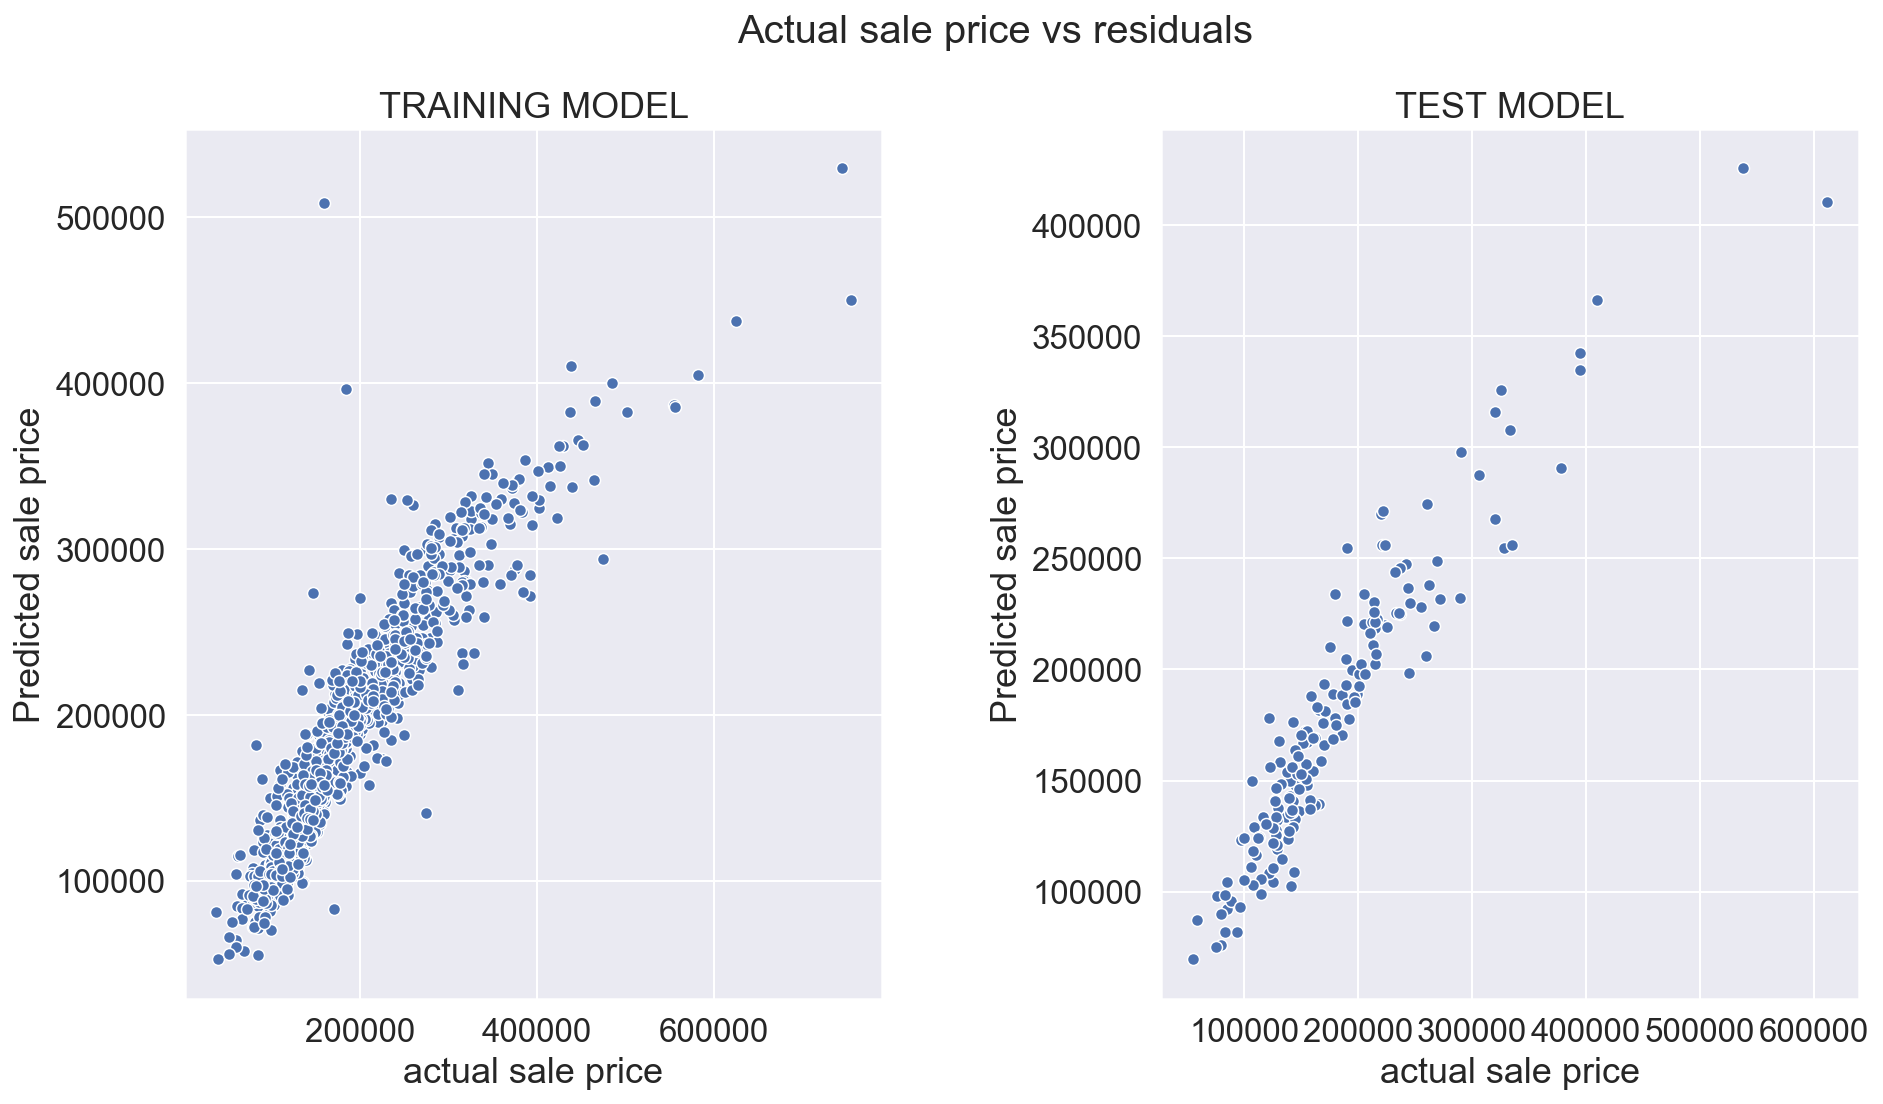

In [71]:
fig,ax=plt.subplots(ncols=2,figsize=(15,8))

fig.subplots_adjust(hspace=1, wspace=0.4)
fig.suptitle('Actual sale price vs residuals',fontsize=20)

ax[0]=sns.scatterplot(y_train,y_hat_train,ax=ax[0])
ax[0].set(title='TRAINING MODEL')
ax[0].set_ylabel('Predicted sale price')
ax[0].set_xlabel('actual sale price');

ax[1]=sns.scatterplot(y_test,y_hat_test,ax=ax[1])
ax[1].set(title='TEST MODEL')
ax[1].set_ylabel('Predicted sale price')
ax[1].set_xlabel('actual sale price');

In [72]:
residuals_test=y_test-y_hat_test
residuals_train=y_train-y_hat_train
residuals_full=y_full-y_hat_full

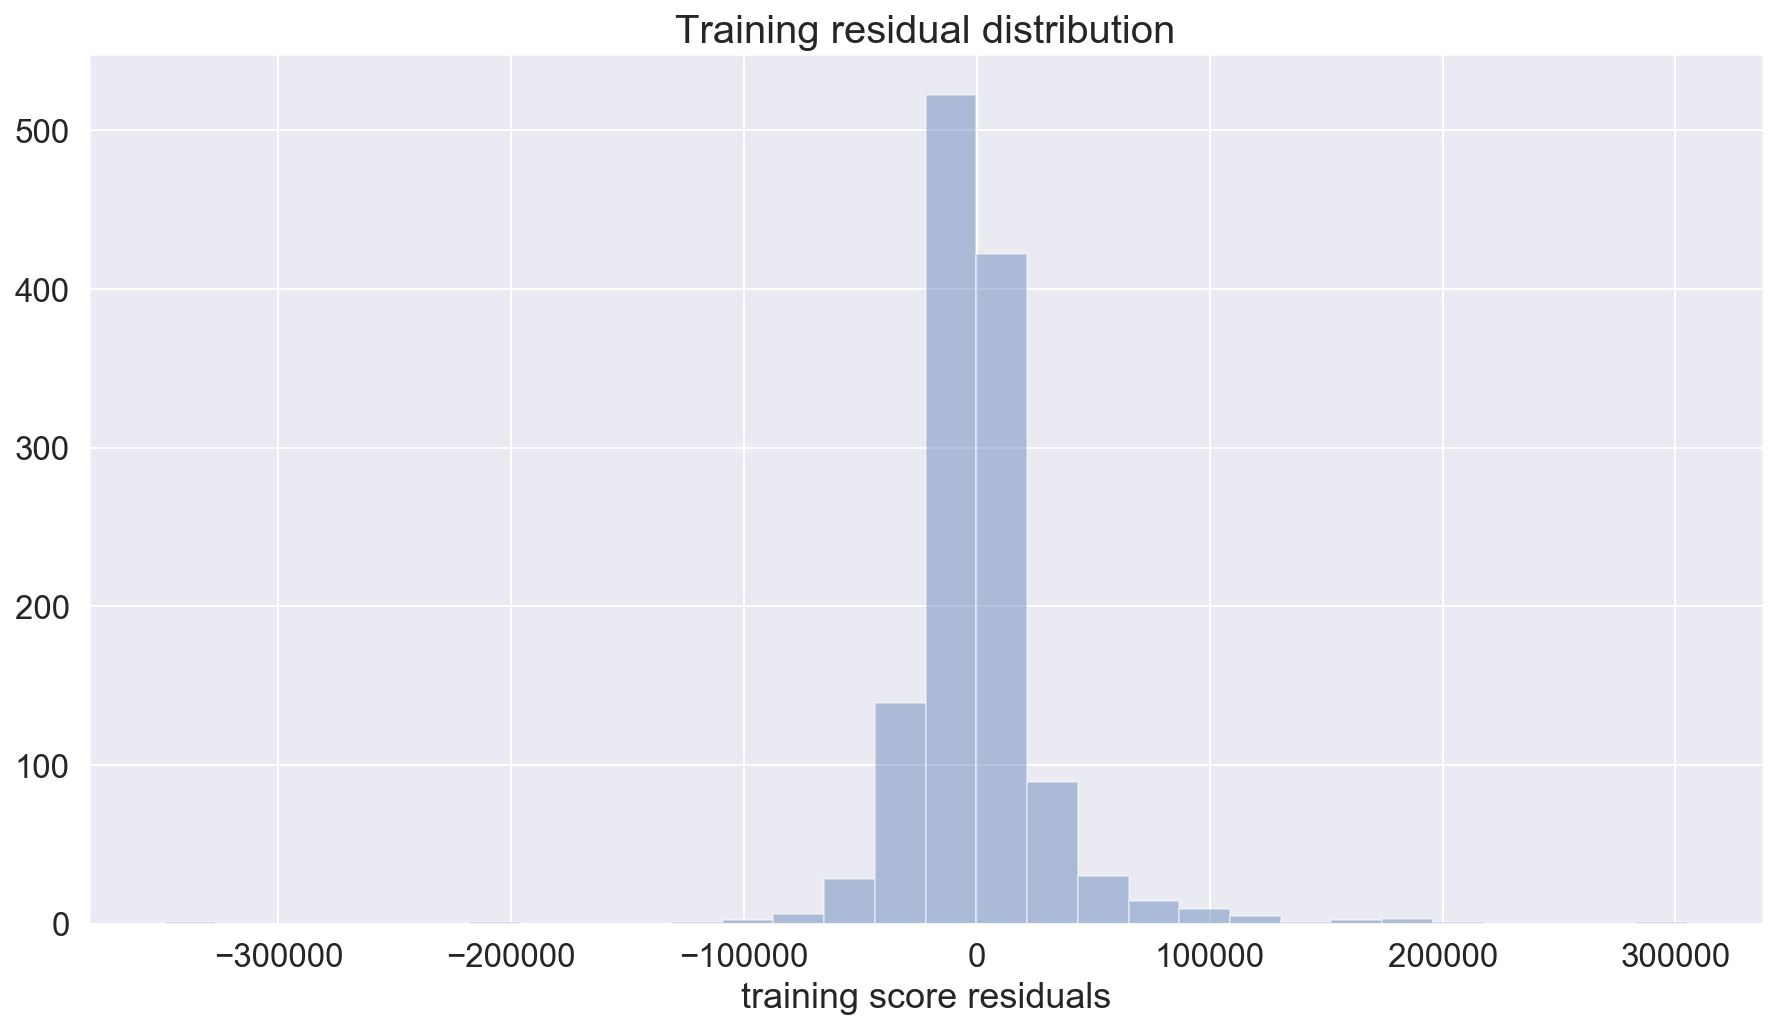

In [73]:
ig,ax=plt.subplots(figsize=(15,8))

fig.subplots_adjust(hspace=1, wspace=0.4)
ax.set_title('Training residual distribution',fontsize=20)

ax=sns.distplot(residuals_train, bins=30,ax=ax,kde=False)

ax.set_xlabel('training score residuals');

## ANSWER

---

The model performs well, with an R2 cross validated score of 0.79, and an R2 test score of 0.842, showing that the model is a good fit. The model does tend to under predict the sale price as the sale price gets higher. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

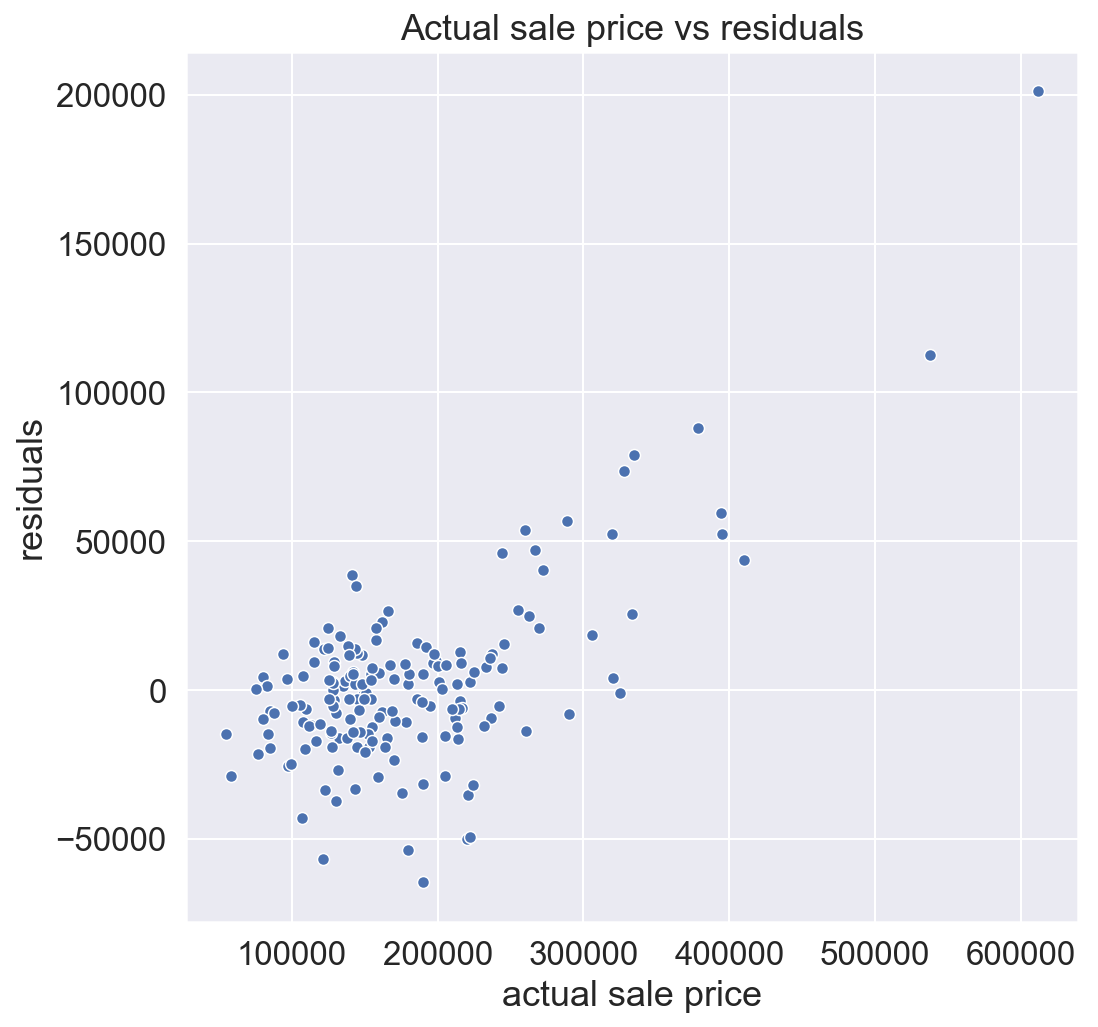

In [74]:
fig,ax=plt.subplots(figsize=(8,8))
ax.set(title='Actual sale price vs residuals')
ax=sns.scatterplot(y_test,residuals_test,ax=ax)
ax.set_ylabel('residuals')
ax.set_xlabel('actual sale price');

In [75]:
residuals_full.abs().mean()

18587.02069235617

In [76]:
house_renovate.columns

Index(['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'Exterior1st', 'Exterior2nd', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'RoofMatl', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'Fence', 'HeatingQC', 'CentralAir', 'Electrical', 'Heating', 'YrSold', 'SalePrice'], dtype='object')

In [77]:
renovate_dummy=['ExterQual', 'ExterCond', 'Exterior1st', 'Exterior2nd', 'BsmtCond', 'BsmtFinType1', 
                'BsmtFinType2', 'RoofMatl', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 
                'GarageCond','Fence', 'HeatingQC', 'CentralAir', 'Electrical', 'Heating']

In [78]:
renovate_numeric=['OverallQual', 'OverallCond','WoodDeckSF']

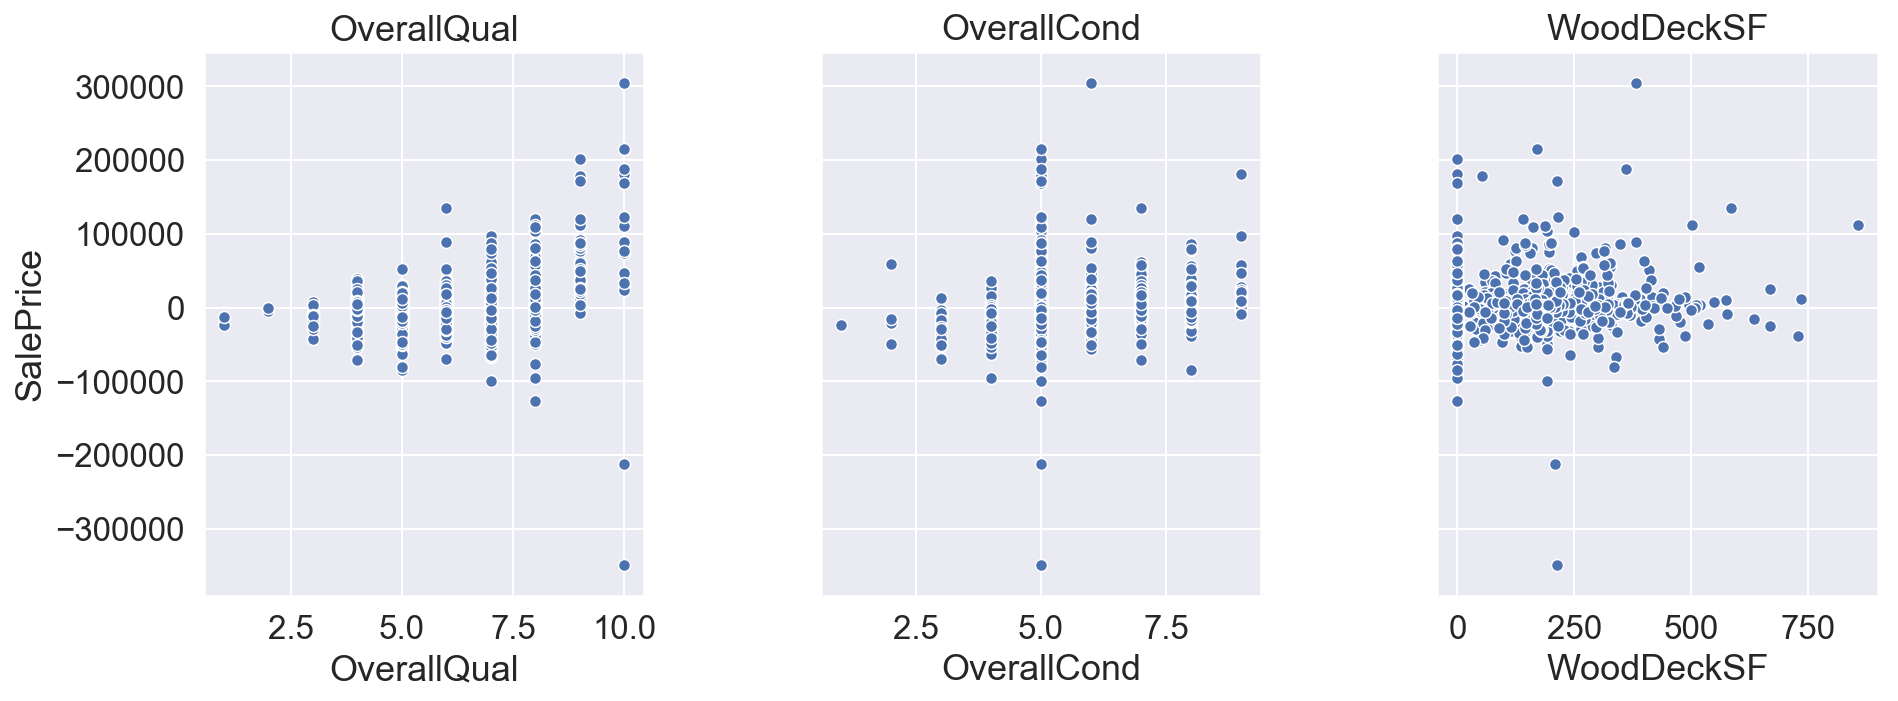

In [79]:
plt_cols=3

fig, ax = plt.subplots(ncols=3,figsize=(15,5),sharey='row')
fig.subplots_adjust(hspace=0.5, wspace=0.4)
count=0
for col in renovate_numeric:

    sns.scatterplot(x=col,y=residuals_full, data=house_renovate,ax=ax[count])
    ax[count].set_title(col)
    count+=1

plt.show()

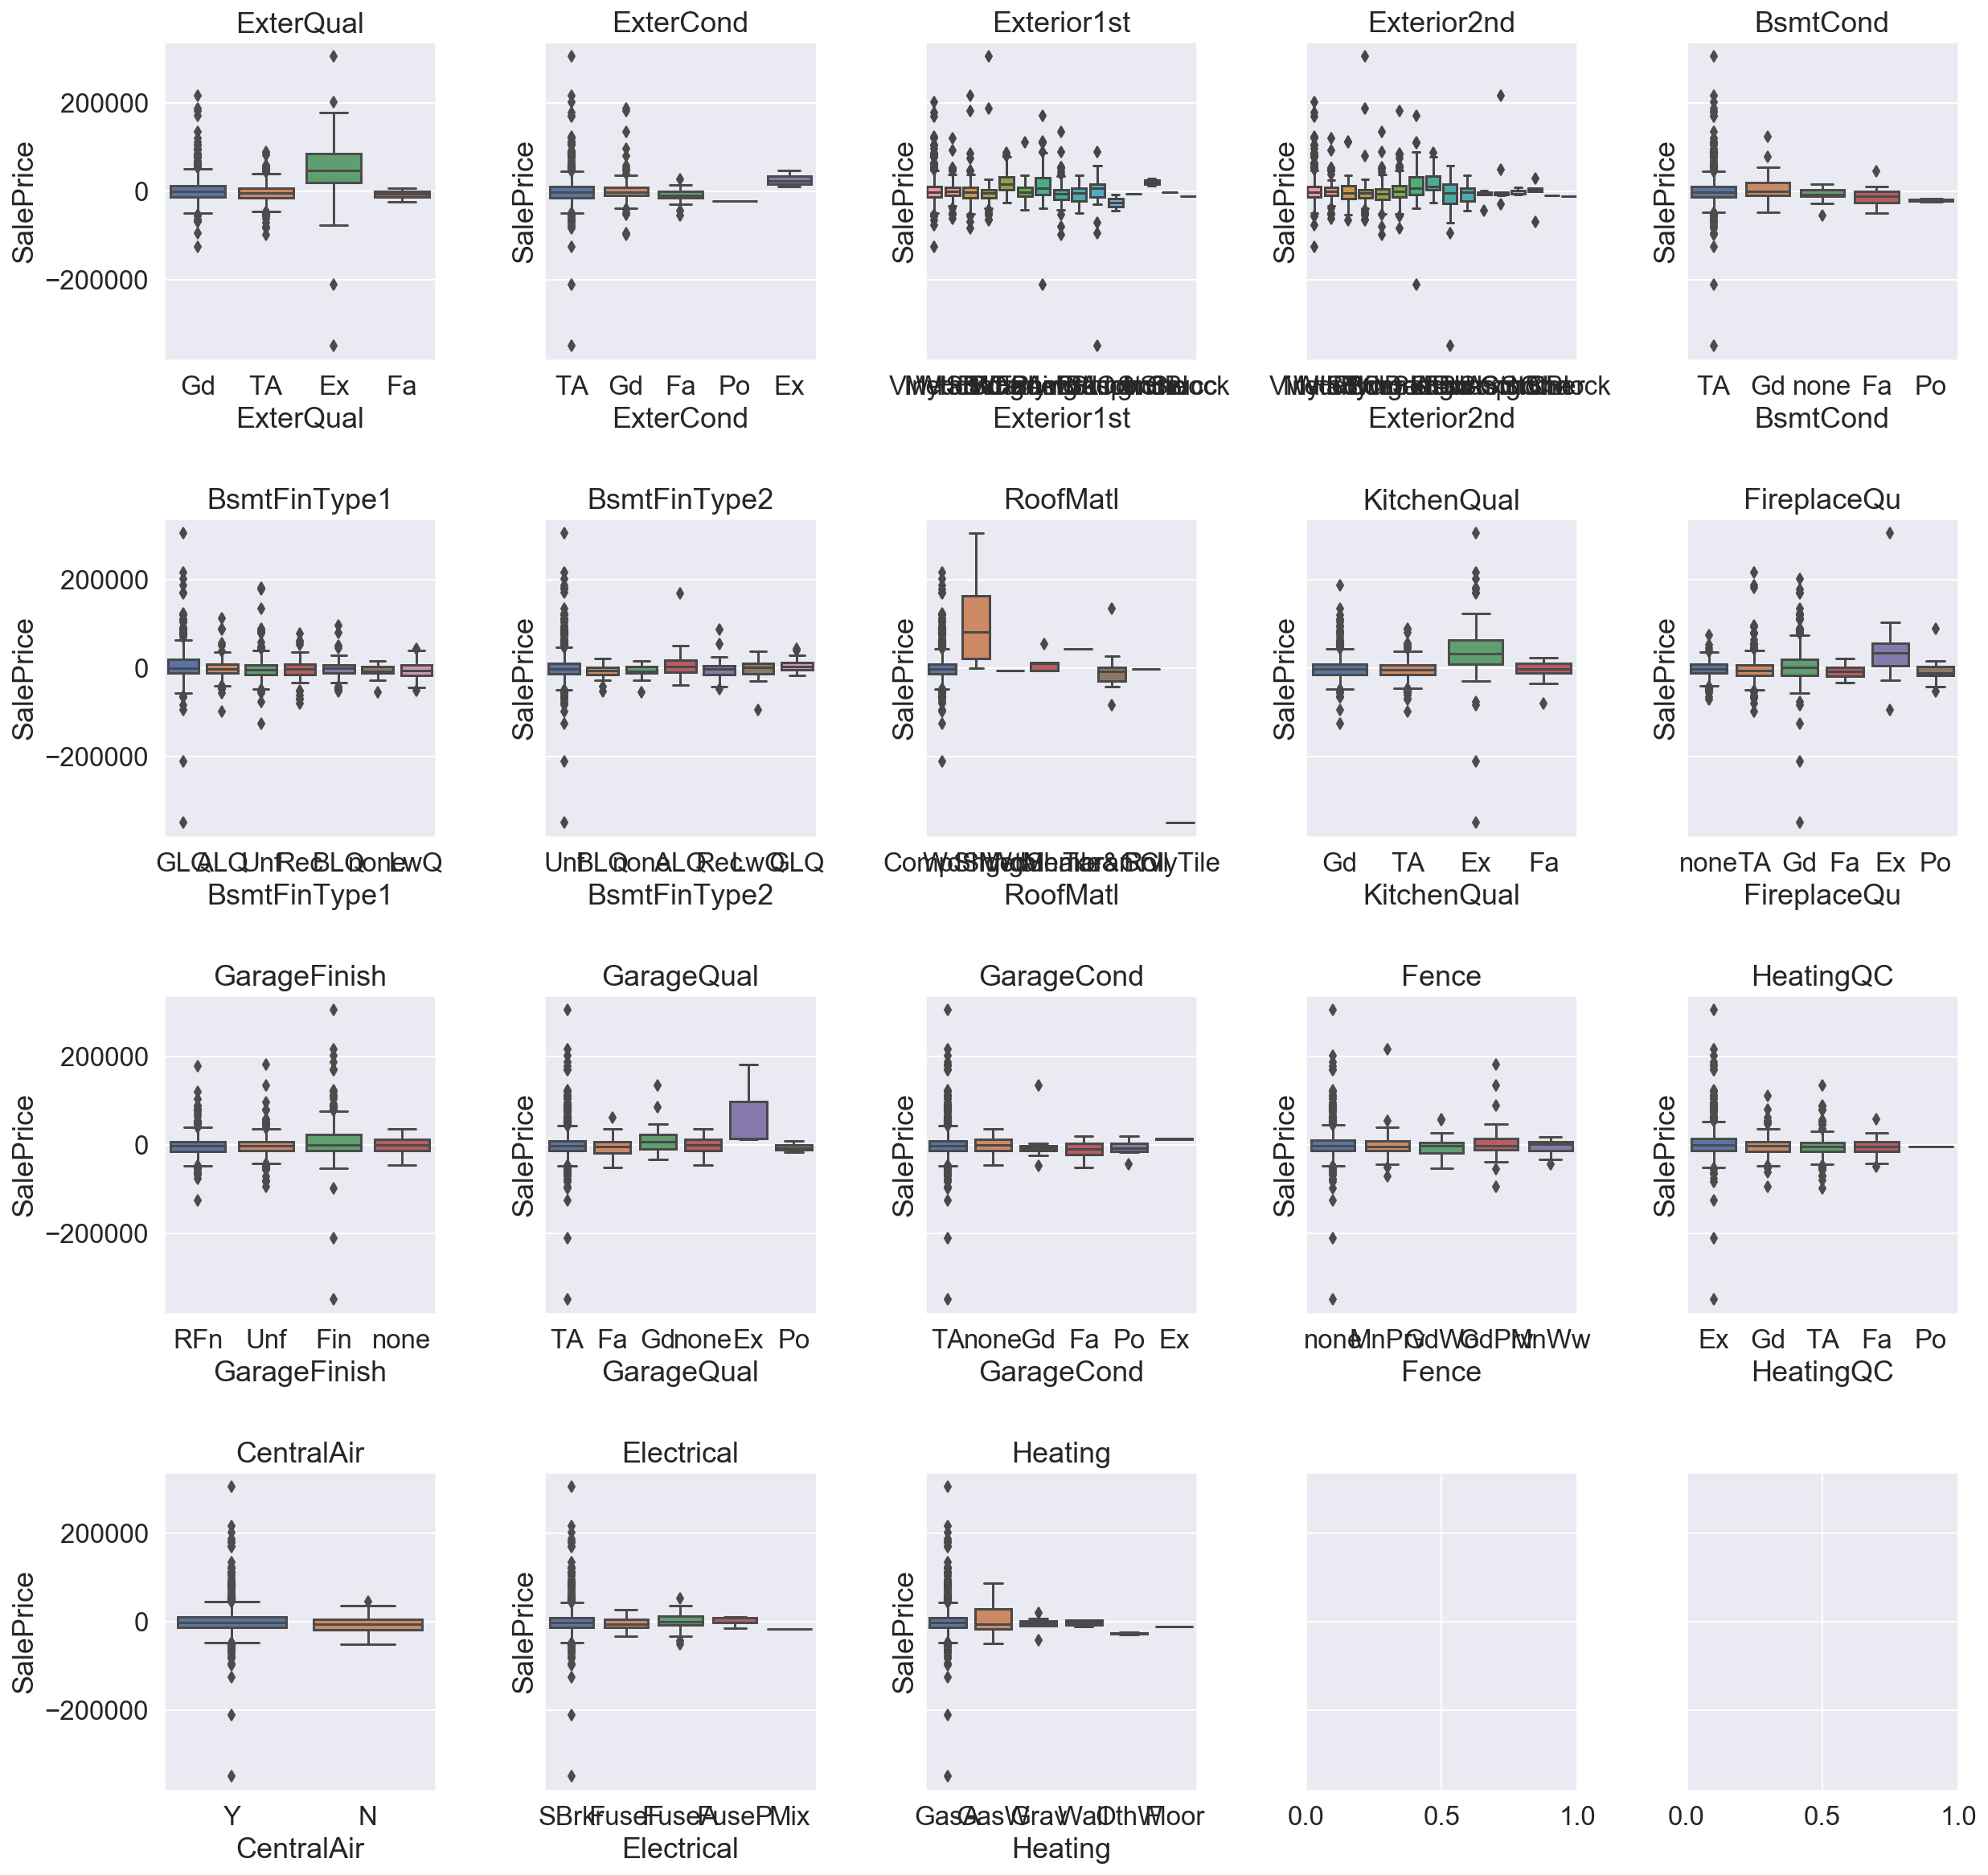

In [80]:
plt_cols=5
plt_rows=int(np.ceil(len(renovate_dummy)/plt_cols))
fig, ax = plt.subplots(plt_rows,plt_cols,figsize=(20,20),sharey='row')
fig.subplots_adjust(hspace=0.5, wspace=0.4)
count=0
for col in renovate_dummy:
    x,y = divmod(count,plt_cols)
    sns.boxplot(x=col,y=residuals_full, data=house_renovate,ax=ax[x,y])
    ax[x,y].set_title(col)
    count+=1

plt.show()

In [81]:
house_renovate.columns

Index(['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'Exterior1st', 'Exterior2nd', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'RoofMatl', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'Fence', 'HeatingQC', 'CentralAir', 'Electrical', 'Heating', 'YrSold', 'SalePrice'], dtype='object')

In [82]:
renovate_feature=['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'Exterior1st', 'Exterior2nd', 'BsmtCond',
                  'BsmtFinType1', 'BsmtFinType2', 'RoofMatl', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual',
                  'GarageCond', 'WoodDeckSF', 'Fence', 'HeatingQC', 'CentralAir', 'Electrical', 'Heating', 'YrSold']

In [83]:
house_dum_reno = pd.get_dummies(house_renovate[renovate_feature], 
                                columns=[col for col in renovate_feature if col in renovate_dummy],
                                drop_first=True)
house_dum_reno.head()

OverallQual  OverallCond  WoodDeckSF  YrSold  ExterQual_Fa  ExterQual_Gd  ExterQual_TA  ExterCond_Fa  ExterCond_Gd  ExterCond_Po  ExterCond_TA  Exterior1st_AsphShn  Exterior1st_BrkComm  Exterior1st_BrkFace  Exterior1st_CBlock  Exterior1st_CemntBd  Exterior1st_HdBoard  Exterior1st_ImStucc  Exterior1st_MetalSd  Exterior1st_Plywood  Exterior1st_Stone  Exterior1st_Stucco  Exterior1st_VinylSd  Exterior1st_Wd Sdng  Exterior1st_WdShing  Exterior2nd_AsphShn  Exterior2nd_Brk Cmn  Exterior2nd_BrkFace  Exterior2nd_CBlock  Exterior2nd_CmentBd  Exterior2nd_HdBoard  Exterior2nd_ImStucc  Exterior2nd_MetalSd  Exterior2nd_Other  Exterior2nd_Plywood  Exterior2nd_Stone  Exterior2nd_Stucco  Exterior2nd_VinylSd  Exterior2nd_Wd Sdng  Exterior2nd_Wd Shng  BsmtCond_Gd  BsmtCond_Po  BsmtCond_TA  BsmtCond_none  BsmtFinType1_BLQ  BsmtFinType1_GLQ  BsmtFinType1_LwQ  BsmtFinType1_Rec  BsmtFinType1_Unf  BsmtFinType1_none  BsmtFinType2_BLQ  BsmtFinType2_GLQ  BsmtFinType2_LwQ  BsmtFinType2_Rec  BsmtFinType2_Unf  \
0            7            5           0    2008             0             1             0             0             0             0             1                    0                    0                    0                   0                    0                    0                    0                    0                    0                  0                   0                    1                    0                    0                    0                    0                    0                   0                    0                    0                    0                    0                  0                    0                  0                   0                    1                    0                    0            0            0            1              0                 0                 1                 0                 0                 0                  0                 0                 0                 0                 0                 1   
1            6            8         298    2007             0             0             1             0             0             0             1                    0                    0                    0                   0                    0                    0                    0                    1                    0                  0                   0                    0                    0                    0                    0                    0                    0                   0                    0                    0                    0                    1                  0                    0                  0                   0                    0                    0                    0            0            0            1              0                 0                 0                 0                 0                 0                  0                 0                 0                 0                 0                 1   
2            7            5           0    2008             0             1             0             0             0             0             1                    0                    0                    0                   0                    0                    0                    0                    0                    0                  0                   0                    1                    0                    0                    0                    0                    0                   0                    0                    0                    0                    0                  0                    0                  0                   0                    1                    0                    0            0            0            1              0                 0                 1                 0                 0                 0                  0                 0                 0                 0                 0                 1   

In [84]:
house_dum_reno=house_dum_reno.join(residuals_full)

In [85]:
house_dum_reno.rename(columns={'SalePrice':'Residuals'},inplace=True)

In [86]:
#house_dum_reno=house_dum_reno.join(house['SalePrice'])

In [87]:
house_dum_reno

OverallQual  OverallCond  WoodDeckSF  YrSold  ExterQual_Fa  ExterQual_Gd  ExterQual_TA  ExterCond_Fa  ExterCond_Gd  ExterCond_Po  ExterCond_TA  Exterior1st_AsphShn  Exterior1st_BrkComm  Exterior1st_BrkFace  Exterior1st_CBlock  Exterior1st_CemntBd  Exterior1st_HdBoard  Exterior1st_ImStucc  Exterior1st_MetalSd  Exterior1st_Plywood  Exterior1st_Stone  Exterior1st_Stucco  Exterior1st_VinylSd  Exterior1st_Wd Sdng  Exterior1st_WdShing  Exterior2nd_AsphShn  Exterior2nd_Brk Cmn  Exterior2nd_BrkFace  Exterior2nd_CBlock  Exterior2nd_CmentBd  Exterior2nd_HdBoard  Exterior2nd_ImStucc  Exterior2nd_MetalSd  Exterior2nd_Other  Exterior2nd_Plywood  Exterior2nd_Stone  Exterior2nd_Stucco  Exterior2nd_VinylSd  Exterior2nd_Wd Sdng  Exterior2nd_Wd Shng  BsmtCond_Gd  BsmtCond_Po  BsmtCond_TA  BsmtCond_none  BsmtFinType1_BLQ  BsmtFinType1_GLQ  BsmtFinType1_LwQ  BsmtFinType1_Rec  BsmtFinType1_Unf  BsmtFinType1_none  BsmtFinType2_BLQ  BsmtFinType2_GLQ  BsmtFinType2_LwQ  BsmtFinType2_Rec  \
0               7            5           0    2008             0             1             0             0             0             0             1                    0                    0                    0                   0                    0                    0                    0                    0                    0                  0                   0                    1                    0                    0                    0                    0                    0                   0                    0                    0                    0                    0                  0                    0                  0                   0                    1                    0                    0            0            0            1              0                 0                 1                 0                 0                 0                  0                 0                 0                 0                 0   
1               6            8         298    2007             0             0             1             0             0             0             1                    0                    0                    0                   0                    0                    0                    0                    1                    0                  0                   0                    0                    0                    0                    0                    0                    0                   0                    0                    0                    0                    1                  0                    0                  0                   0                    0                    0                    0            0            0            1              0                 0                 0                 0                 0                 0                  0                 0                 0                 0                 0   
2               7            5           0    2008             0             1             0             0             0             0             1                    0                    0                    0                   0                    0                    0                    0                    0                    0                  0                   0                    1                    0                    0                    0                    0                    0                   0                    0                    0                    0                    0                  0                    0                  0                   0                    1                    0                    0            0            0            1              0                 0                 1                 0                 0                 0                  0                 0                 0                 0                 0   
3               7            5           0    2006            

In [88]:
    #Create a training data subset based on all sales prior to 2010

X_res_train = house_dum_reno[house_dum_reno['YrSold']<2010].drop(columns=["Residuals",'YrSold'])
y_res_train = house_dum_reno[house_dum_reno['YrSold']<2010].pop("Residuals")

In [89]:
#Create a test Data subset based on 2010 sales
y_res_test = house_dum_reno[house_dum_reno['YrSold']==2010].pop("Residuals")
X_res_test = house_dum_reno[house_dum_reno['YrSold']==2010].drop(columns=["Residuals",'YrSold'])

In [90]:
# standardize the data
# scaler = StandardScaler()
# X_res_train = pd.DataFrame(scaler.fit_transform(X_res_train), columns=X_res_train.columns)
# X_res_test = pd.DataFrame(scaler.transform(X_res_test), columns=X_res_test.columns)

In [91]:
X_res_train.describe()

OverallQual  OverallCond   WoodDeckSF  ExterQual_Fa  ExterQual_Gd  ExterQual_TA  ExterCond_Fa  ExterCond_Gd  ExterCond_Po  ExterCond_TA  Exterior1st_AsphShn  Exterior1st_BrkComm  Exterior1st_BrkFace  Exterior1st_CBlock  Exterior1st_CemntBd  Exterior1st_HdBoard  Exterior1st_ImStucc  Exterior1st_MetalSd  Exterior1st_Plywood  Exterior1st_Stone  Exterior1st_Stucco  Exterior1st_VinylSd  Exterior1st_Wd Sdng  Exterior1st_WdShing  Exterior2nd_AsphShn  Exterior2nd_Brk Cmn  Exterior2nd_BrkFace  Exterior2nd_CBlock  Exterior2nd_CmentBd  Exterior2nd_HdBoard  Exterior2nd_ImStucc  Exterior2nd_MetalSd  Exterior2nd_Other  Exterior2nd_Plywood  Exterior2nd_Stone  Exterior2nd_Stucco  Exterior2nd_VinylSd  Exterior2nd_Wd Sdng  Exterior2nd_Wd Shng  BsmtCond_Gd  BsmtCond_Po  BsmtCond_TA  BsmtCond_none  BsmtFinType1_BLQ  BsmtFinType1_GLQ  BsmtFinType1_LwQ  BsmtFinType1_Rec  BsmtFinType1_Unf  BsmtFinType1_none  BsmtFinType2_BLQ  BsmtFinType2_GLQ  BsmtFinType2_LwQ  BsmtFinType2_Rec  BsmtFinType2_Unf  \
count  1277.000000  1277.000000  1277.000000   1277.000000   1277.000000   1277.000000   1277.000000   1277.000000        1277.0   1277.000000               1277.0          1277.000000          1277.000000         1277.000000          1277.000000          1277.000000          1277.000000          1277.000000          1277.000000        1277.000000         1277.000000          1277.000000          1277.000000          1277.000000          1277.000000          1277.000000          1277.000000         1277.000000          1277.000000          1277.000000          1277.000000          1277.000000        1277.000000          1277.000000        1277.000000         1277.000000          1277.000000          1277.000000          1277.000000  1277.000000  1277.000000  1277.000000    1277.000000       1277.000000       1277.000000       1277.000000       1277.000000       1277.000000        1277.000000       1277.000000       1277.000000       1277.000000       1277.000000       1277.000000   
mean      6.126860     5.574785    93.541895      0.007048      0.341425      0.616288      0.017228      0.097103           0.0      0.883320                  0.0             0.001566             0.031323            0.000783             0.042287             0.151919             0.000783             0.149569             0.068912           0.001566            0.017228             0.357870             0.142522             0.019577             0.001566             0.004699             0.016445            0.000783             0.041504             0.138606             0.007048             0.146437           0.000783             0.092404           0.003915            0.018794             0.352388             0.136257             0.025059     0.048551     0.001566     0.893500       0.025059          0.099452          0.281128          0.050117          0.091621          0.299922           0.025059          0.021143          0.008614          0.032890          0.035239          0.863743   
std       1.380975     1.102188   123.740555      0.083687      0.474374      0.486480      0.130170      0.296213           0.0      0.321164                  0.0             0.039559             0.174259            0.027984             0.201321             0.359083             0.027984             0.356788             0.253403           0.039559            0.130170             0.479561             0.349721             0.138596             0.039559             0.068411             0.127228            0.027984             0.199530             0.345670             0.083687             0.353682           0.027984             0.289709           0.062475            0.135850             0.477901             0.343196             0.156365     0.215012     0.039559     0.308597       0.156365          0.299385          0.449726          0.218273          0.288603          0.458403           0.156365          0.143918          0.092447          0.178417          0.184455          0.343196   
min       1.000

In [92]:
y_res_train.shape

(1277,)

In [93]:
X_res_test.shape

(172, 101)

In [94]:
y_res_test.shape

(172,)

In [95]:
part_2_results={}

In [96]:
# create a linear regression model instance
lr_model = LinearRegression()

# get cross validated scores
scores = cross_val_score(lr_model, X_res_train, y_res_train, cv=10)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
lr_model.fit(X_res_train, y_res_train)
print("Training Score:", lr_model.score(X_res_train, y_res_train))

part_2_results['linear_regression']={'cross_val_scores':scores, 
                              "Mean cross-validated training score": scores.mean(),
                             'Training score':lr_model.score(X_res_train, y_res_train)}

Cross-validated training scores: [-2.47858268 -1.14931033  0.28496973 -0.12018539  0.35357285  0.20795247
  0.03399596 -0.04788349 -0.03419359  0.10891539]
Mean cross-validated training score: -0.2840749069362417
Training Score: 0.4063223040707986


In [97]:
# create a LassoCV model instance
LCV_model = LassoCV(n_alphas=1000, cv=10)
# fit the model
LCV_model.fit(X_res_train, y_res_train)
# get the best alpha
print('Best alpha:', LCV_model.alpha_)
# evaluate on the training set
print('Training score:', LCV_model.score(X_res_train, y_res_train))
part_2_results['LassoCV']={'Best alpha': LCV_model.alpha_,
                             'Training score':LCV_model.score(X_res_train, y_res_train)}

Best alpha: 490.57909789127484
Training score: 0.184915627128017


In [98]:
# create a Lasso model instance
L_model = Lasso(alpha=LCV_model.alpha_)

# get cross validated scores
L_scores = cross_val_score(L_model, X_res_train, y_res_train, cv=10)
print("Cross-validated training scores:", L_scores)
print("Mean cross-validated training score:", L_scores.mean())
# fit and evaluate the data on the whole training set
L_model.fit(X_res_train, y_res_train)
print("Training Score:", L_model.score(X_res_train, y_res_train))
part_2_results['Lasso']={'cross_val_score':L_scores, 
                              "Mean cross-validated training score": L_scores.mean(),
                             'Training score':L_model.score(X_res_train, y_res_train)}

Cross-validated training scores: [0.09315362 0.27160375 0.23175169 0.04885495 0.22686806 0.21474157
 0.1092208  0.18592201 0.06555618 0.21003911]
Mean cross-validated training score: 0.16577117344944234
Training Score: 0.184915627128017


In [99]:
# create a Elastic Net CV model instance
E_model = ElasticNetCV(l1_ratio=np.linspace(0.990,1,20), 
                     n_alphas=200,cv=10)
# fit the model
E_model.fit(X_res_train, y_res_train)
# get the best alpha
print('Best alpha:', E_model.alpha_)
print('Best L1:', E_model.l1_ratio_)
# evaluate on the training set
print('Training score:', E_model.score(X_res_train, y_res_train))
part_2_results['elastic_net_CV']={'Best alpha': E_model.alpha_,
                             'Training score':E_model.score(X_res_train, y_res_train),
                            'Best L1': E_model.l1_ratio_}

Best alpha: 490.57909789127484
Best L1: 1.0
Training score: 0.184915627128017


In [100]:
# create a RidgeCV model instance
RCV_model = RidgeCV(alphas=np.linspace(0.990,1,20), cv=10)
# fit the model
RCV_model.fit(X_res_train, y_res_train)
# get the best alpha
print('Best alpha:', RCV_model.alpha_)
# evaluate on the training set
print('Training score:', RCV_model.score(X_res_train, y_res_train))
part_2_results['LassoCV']={'Best alpha': RCV_model.alpha_,
                             'Training score':RCV_model.score(X_res_train, y_res_train)}

Best alpha: 1.0
Training score: 0.3089453037345511


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [101]:
# create a Ridge model instance
R_model = Ridge(alpha=RCV_model.alpha_)

# get cross validated scores
R_scores = cross_val_score(L_model, X_res_train, y_res_train, cv=10)
print("Cross-validated training scores:", R_scores)
print("Mean cross-validated training score:", R_scores.mean())
# fit and evaluate the data on the whole training set
R_model.fit(X_res_train, y_res_train)
print("Training Score:", R_model.score(X_res_train, y_res_train))
part_2_results['Lasso']={'cross_val_score':R_scores, 
                              "Mean cross-validated training score": R_scores.mean(),
                             'Training score':R_model.score(X_res_train, y_res_train)}

Cross-validated training scores: [0.09315362 0.27160375 0.23175169 0.04885495 0.22686806 0.21474157
 0.1092208  0.18592201 0.06555618 0.21003911]
Mean cross-validated training score: 0.16577117344944234
Training Score: 0.3089453037345511


In [102]:
# collect the model coefficients in a dataframe
R_coef = pd.DataFrame(R_model.coef_, index=X_res_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
R_coef['coef_abs'] = R_coef.coefficients.abs()

In [103]:
R_coef[R_coef['coef_abs']>0].sort_values(by='coef_abs',ascending=False)

coefficients       coef_abs
RoofMatl_WdShngl     113270.526662  113270.526662
RoofMatl_CompShg      50768.539168   50768.539168
RoofMatl_Tar&Grv      40665.982441   40665.982441
RoofMatl_Membran      36272.121732   36272.121732
RoofMatl_WdShake      35276.540353   35276.540353
RoofMatl_Metal        26262.419333   26262.419333
RoofMatl_Roll         22895.928240   22895.928240
Heating_OthW         -22146.300626   22146.300626
Exterior2nd_Stucco   -20250.218480   20250.218480
KitchenQual_Gd       -19298.666062   19298.666062
GarageQual_Fa        -18095.737396   18095.737396
Exterior2nd_ImStucc   16742.880065   16742.880065
GarageQual_TA        -16709.273242   16709.273242
KitchenQual_TA       -16285.490400   16285.490400
Exterior1st_BrkFace   14590.211852   14590.211852
FireplaceQu_Fa       -14552.908747   14552.908747
KitchenQual_Fa       -14032.715330   14032.715330
Heating_GasW          11973.258933   11973.258933
BsmtFinType2_BLQ     -11100.572251   11100.572251
Exterior2nd_Stone    -10942.280775   10942.280775
Exterior2nd_Wd Shng  -10866.221706   10866.221706
FireplaceQu_TA       -10010.504515   10010.504515
ExterQual_TA          -9891.677582    9891.677582
Exterior1st_ImStucc   -9437.866003    9437.866003
Exterior1st_Stone      9243.128487    9243.128487
FireplaceQu_Gd        -9006.686562    9006.686562
BsmtCond_Po            8314.390911    8314.390911
GarageQual_Po         -8276.585789    8276.585789
ExterQual_Gd          -8234.771222    8234.771222
Exterior2nd_Other     -7855.951365    7855.951365
BsmtFinType2_Rec      -7669.008126    7669.008126
Exterior1st_Stucco    -7614.334762    7614.334762
Exterior1st_BrkComm   -7379.303794    7379.303794
Electrical_SBrkr      -7263.840114    7263.840114
Exterior2nd_HdBoard   -7209.772080    7209.772080
BsmtFinType2_none     -7047.941731    7047.941731
BsmtFinType2_Unf      -6873.449827    6873.449827
Exterior1st_VinylSd   -6698.000173    6698.000173
HeatingQC_Po          -6656.965353    6656.965353
Heating_Wall           6654.176965    6654.176965
OverallQual            6645.978254    6645.978254
BsmtCond_TA            6186.581893    6186.581893
FireplaceQu_none      -6144.879953    6144.879953
OverallCond            6090.135994    6090.135994
GarageCond_Po         -5947.588074    5947.588074
BsmtFinType2_LwQ      -5875.103637    5875.103637
ExterCond_Fa           5872.383221    5872.383221
Exterior1st_Wd Sdng   -5824.124905    5824.124905
BsmtCond_none          5543.646005    5543.646005
BsmtFinType1_none      5543.646005    5543.646005
Exterior1st_Plywood   -4852.281633    4852.281633
Exterior2nd_CBlock    -4747.716971    4747.716971
Exterior1st_CBlock    -4747.716971    4747.716971
Electrical_FuseP      -4514.678328    4514.678328
BsmtCond_Gd            4499.497313    4499.497313
ExterCond_TA           4431.291761    4431.291761
GarageQual_Gd         -4377.991951    4377.991951
Exterior2nd_AsphShn   -4366.430211    4366.430211
GarageCond_Gd          4156.324243    4156.324243
Exterior2nd_CmentBd   -4094.493694    4094.493694
Fence_GdWo             4089.516578    4089.516578
FireplaceQu_Po        -4084.036968    4084.036968
BsmtFinType1_BLQ       4016.759935    4016.759935
Exterior2nd_MetalSd   -3759.867961    3759.867961
GarageFinish_Unf       3294.071192    3294.071192
HeatingQC_Gd          -3200.284168    3200.284168
BsmtFinType1_Unf      -3134.692800    3134.692800
Fence_none             2734.515235    2734.515235
GarageFinish_RFn      -2674.255038    2674.255038
BsmtFinType2_GLQ       2599.213713    2599.213713
HeatingQC_TA          -2559.431376    2559.431376
Fence_MnWw            -2542.153919    2542.153919
BsmtFinType1_Rec       2541.689139    2541.689139
Exterior1st_WdShing    2260.100242    2260.100242
BsmtFinType1_GLQ       2248.560511    2248.560511
Fence_MnPrv            2207.064174    2207.064174
ExterCond_Gd           2045.818573    2045.818573
Electrical_Mix         1908.755133    1908.755133
GarageFinish_none     -1718.681208    1718.681208
GarageQual_none       

Lasso provides the highest cross validated score of 0.16 and will be the model chosen

In [104]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(L_model.coef_, index=X_res_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()

In [105]:
df_coef[df_coef['coef_abs']>0].sort_values(by='coef_abs',ascending=False)

coefficients     coef_abs
KitchenQual_Gd       -9549.251760  9549.251760
OverallQual           7576.488868  7576.488868
Exterior1st_BrkFace   6458.886870  6458.886870
OverallCond           5156.996215  5156.996215
KitchenQual_TA       -4994.673681  4994.673681
GarageFinish_RFn     -3378.345616  3378.345616
BsmtFinType1_Unf     -2755.284202  2755.284202
FireplaceQu_TA       -2091.762876  2091.762876
Electrical_SBrkr     -1569.789696  1569.789696
GarageQual_TA        -1357.689780  1357.689780
FireplaceQu_none       729.251552   729.251552
ExterQual_TA          -453.473776   453.473776
Exterior2nd_HdBoard   -197.143554   197.143554
WoodDeckSF              17.336935    17.336935

In [106]:
print("Elastic Net Test Score:", L_model.score(X_res_test, y_res_test))

Elastic Net Test Score: 0.20582947901158133


In [107]:
L_model.predict(X_res_test);

In [108]:
y_hat_test=L_model.predict(X_res_test)
y_hat_train=L_model.predict(X_res_train)

In [109]:
residuals=y_res_train-y_hat_train

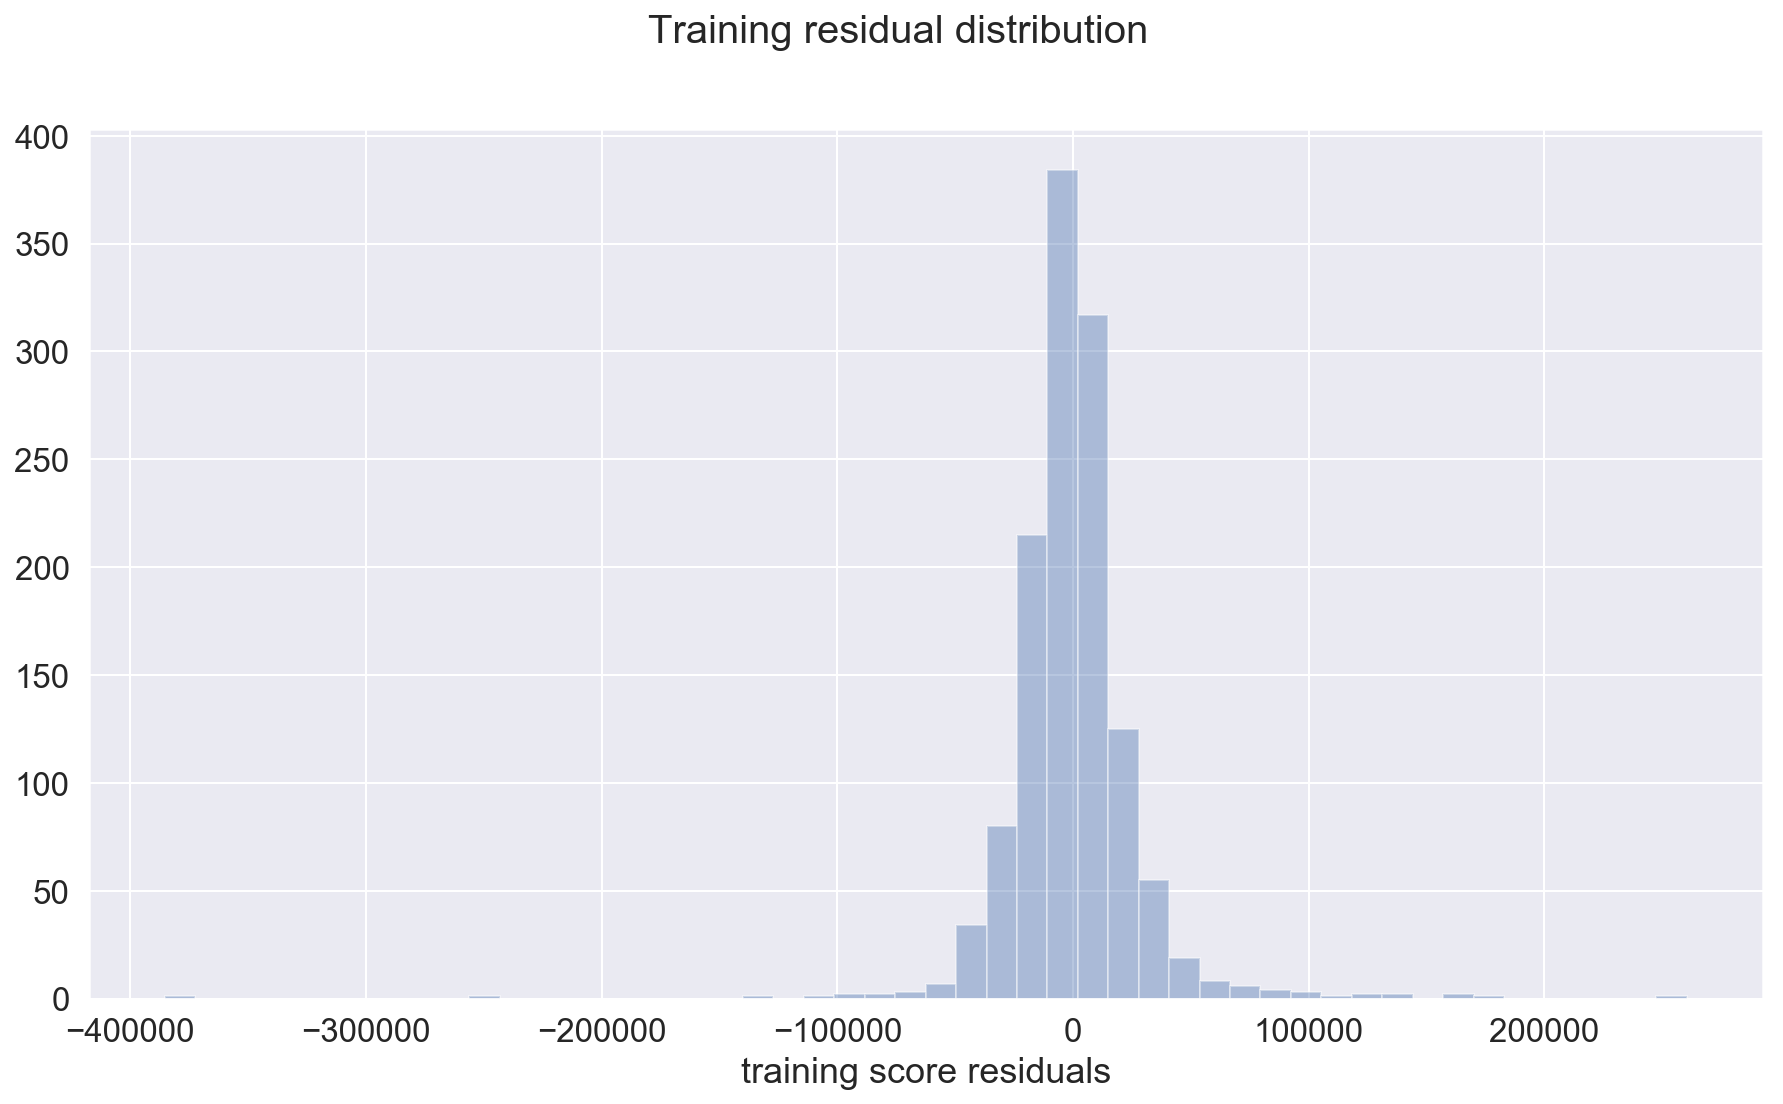

In [110]:
fig,ax=plt.subplots(figsize=(15,8))

fig.subplots_adjust(hspace=1, wspace=0.4)
fig.suptitle('Training residual distribution',fontsize=20)

ax=sns.distplot(residuals, bins=50,ax=ax,kde=False)

ax.set_xlabel('training score residuals');

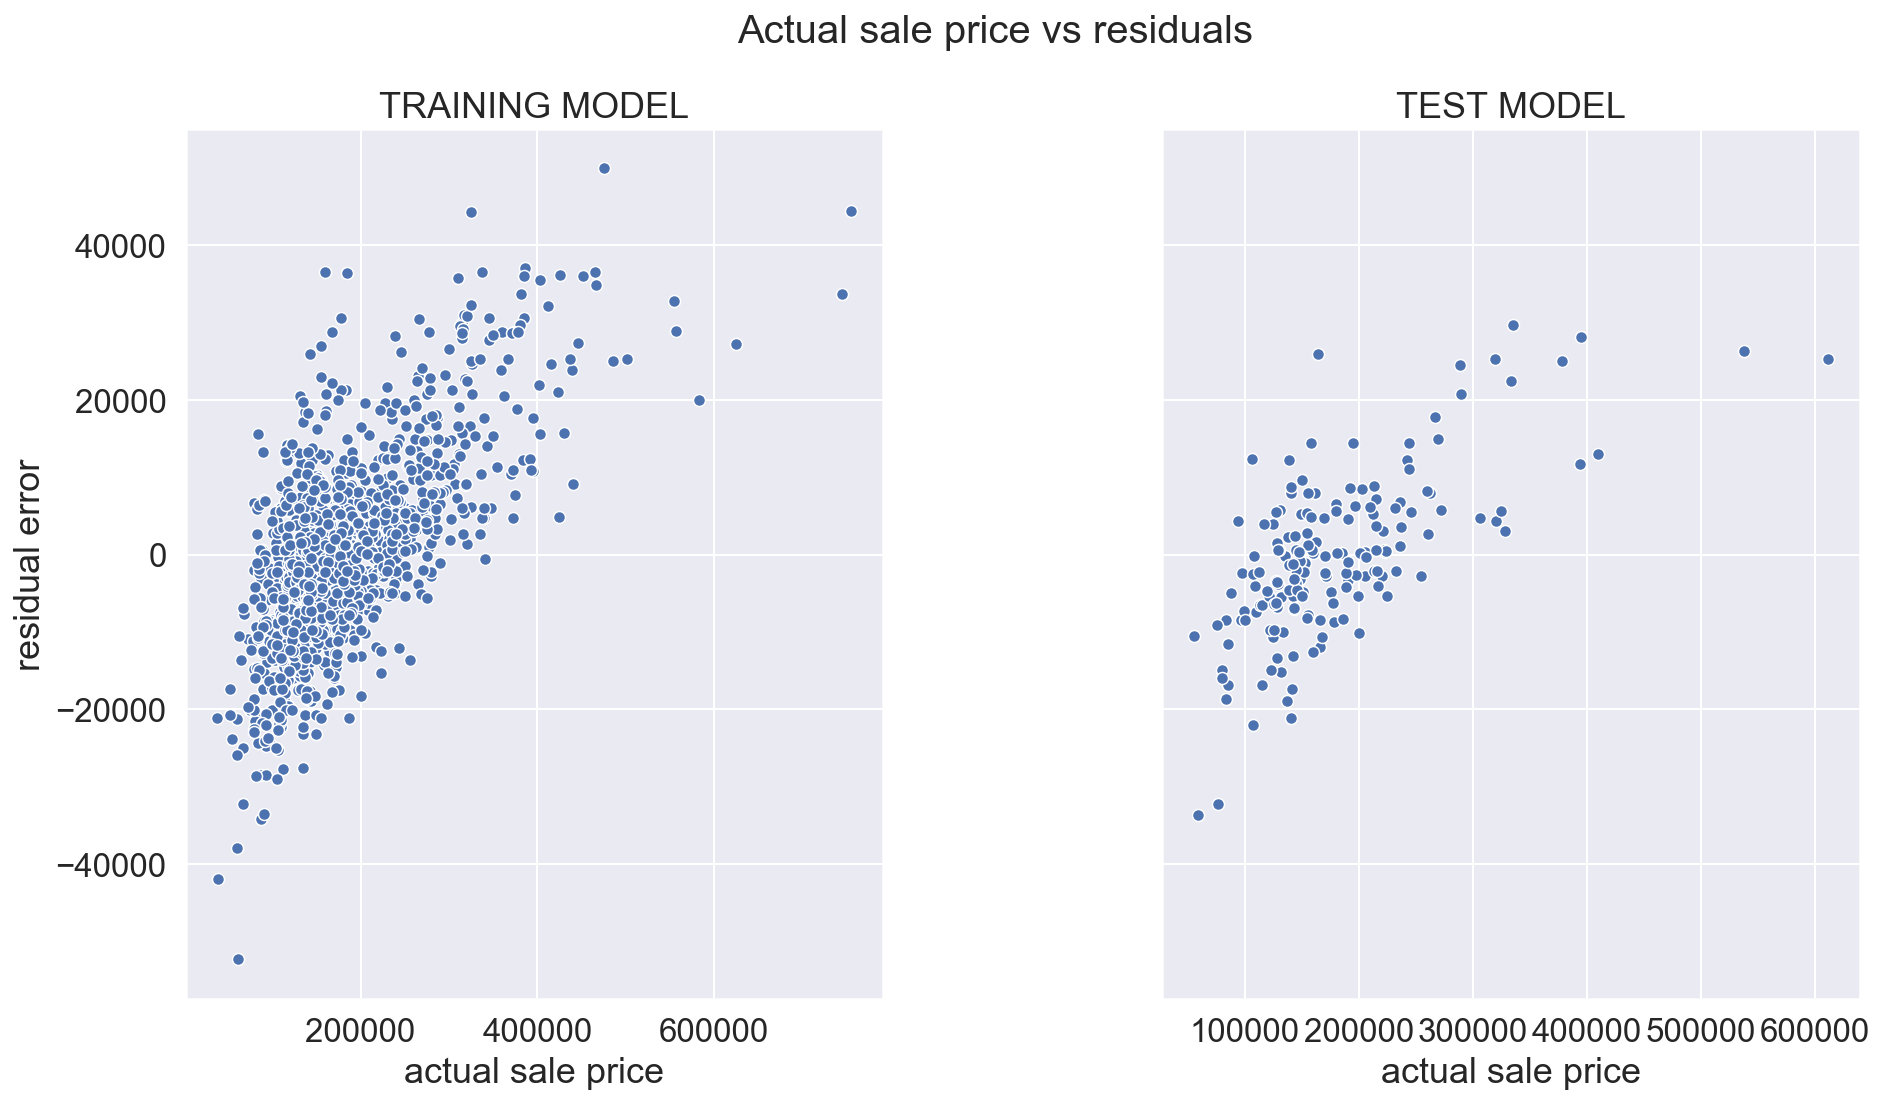

In [111]:
fig,ax=plt.subplots(ncols=2,figsize=(15,8),sharey=True)

fig.subplots_adjust(hspace=1, wspace=0.4)
fig.suptitle('Actual sale price vs residuals',fontsize=20)

ax[0]=sns.scatterplot(y_train,y_hat_train,ax=ax[0])
ax[0].set(title='TRAINING MODEL')
ax[0].set_ylabel('residual error')
ax[0].set_xlabel('actual sale price');

ax[1]=sns.scatterplot(y_test,y_hat_test,ax=ax[1])
ax[1].set(title='TEST MODEL')
ax[1].set_xlabel('actual sale price');

The residuals from this model show that the model can predict within +-$40000, which is still quite a large error. The R2 score for this model is 0.16 is quite low, but is still better than the baseline. I do not think this model would be particularly usefull due to the large amount of variance.

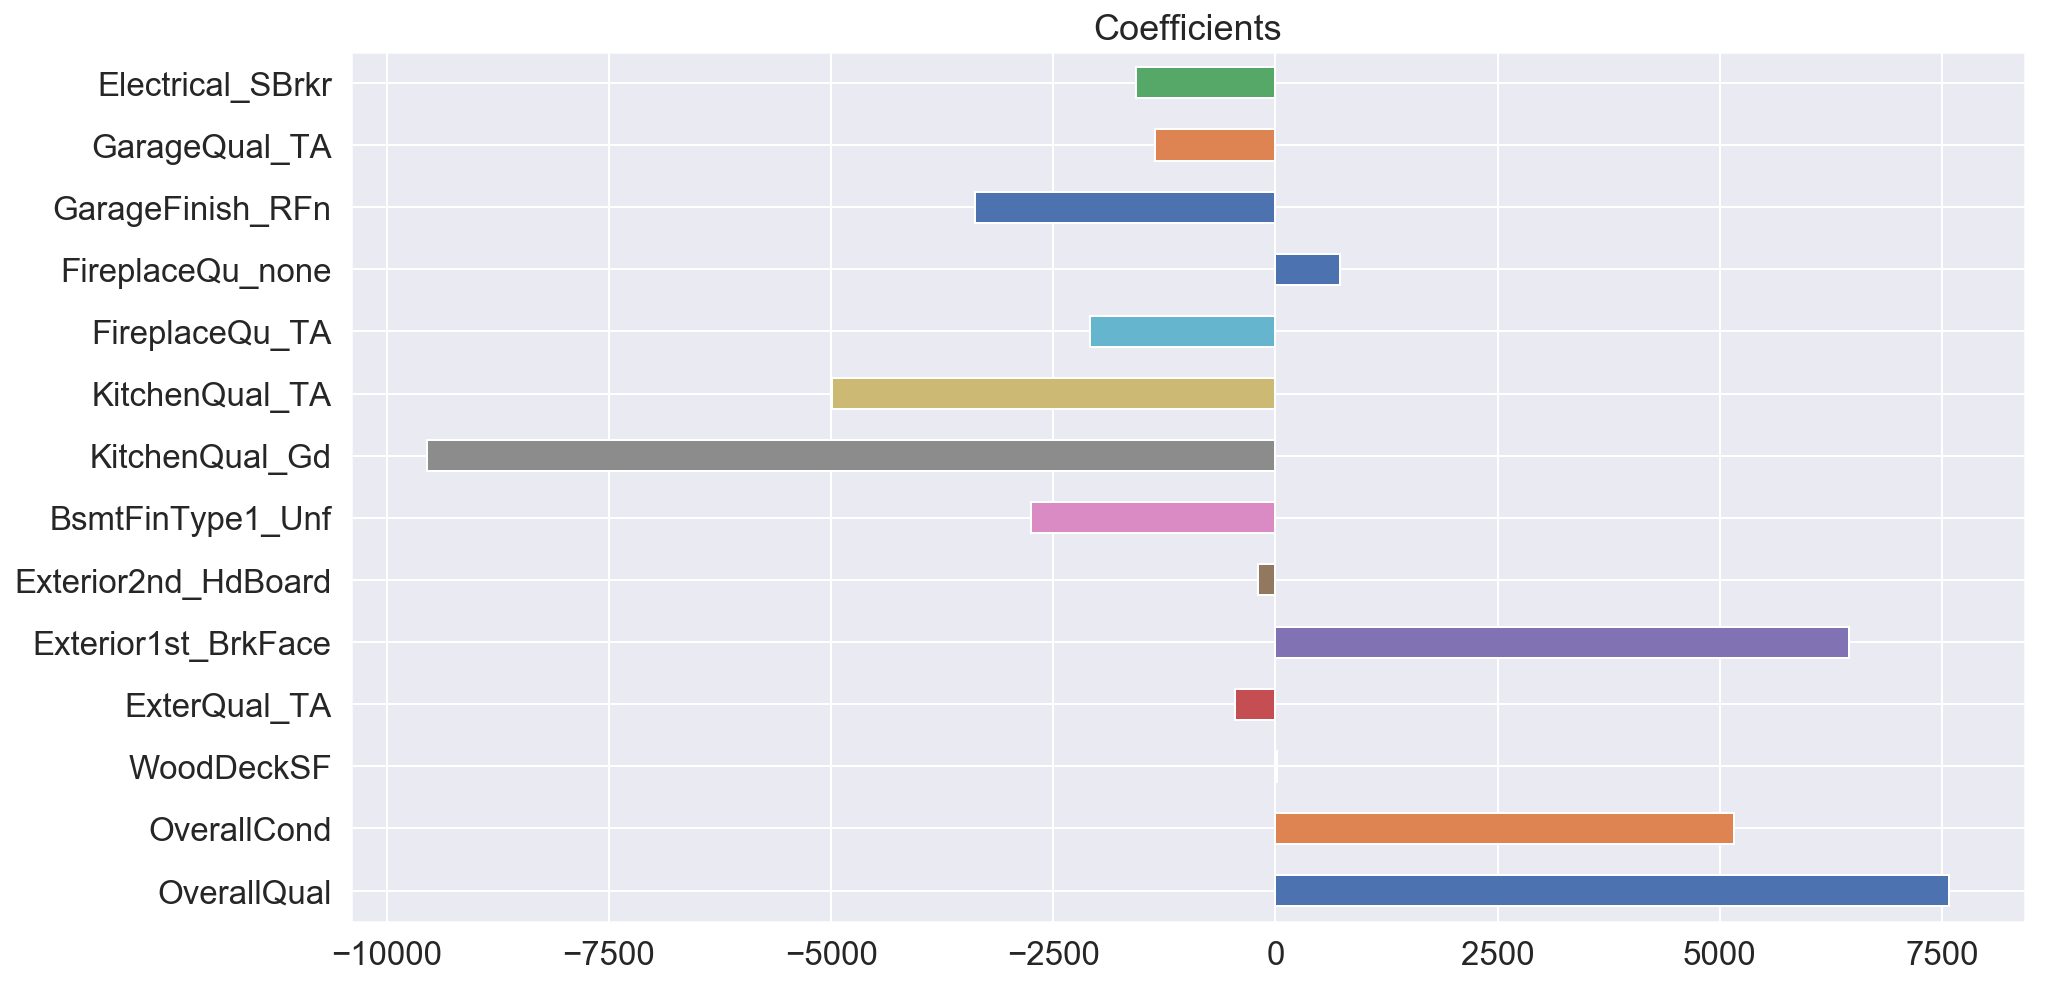

In [112]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Coefficients')
ax = df_coef[df_coef['coef_abs']>0]['coefficients'].plot(kind='barh', ax=ax);

How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money.

The second model can be used to detirmine wether a property should be bought by working out how far below the predicted sale price the actual sale price(offer price) is and given the predictor values what can be improved to increase the sale price when resold. For example, if a house has a poor quality kitchen, and is upgraded to an excellent quality kitchen then the house value should increase by approximatly 9550. in addition to that, each sq meter of wooden deck added to the house increases the value by 13. changing the cladding to brick will increase the value of the property by 7500, however this benifit may be outweighed by the cost of installation.


Do you trust your model? Should it be used to evaluate which properties to buy and fix up?
I do not believe that this model is very suitable for evaluating which properties to buy, as there is too much variance in the residuals.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [113]:
house_dum.dropna(inplace=True)
house_dum=house_dum.join(house["SaleCondition"])
house_dum = house_dum[house_dum["SaleCondition"]!='AdjLand']

In [114]:
#Create a training data subset based on all sales prior to 2010
y_train = house_dum[house_dum['YrSold']<2010].pop("SaleCondition")
X_train = house_dum[house_dum['YrSold']<2010].drop(columns=["SaleCondition",'YrSold'])
#Create a test Data subset based on 2010 sales
y_test = house_dum[house_dum['YrSold']==2010].pop("SaleCondition")
X_test = house_dum[house_dum['YrSold']==2010].drop(columns=["SaleCondition",'YrSold'])

In [115]:
y_train.value_counts()

Normal     1039
Partial     118
Abnorml      87
Family       18
Alloca       11
Name: SaleCondition, dtype: int64

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [117]:
knn_params = {
    'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}

knn_gridsearch = GridSearchCV(KNeighborsClassifier(),
                              knn_params,
                              n_jobs=-1, cv=5, verbose=1)

knn_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    6.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [5, 9, 15, 25, 40, 50, 60], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [118]:
knn_gridsearch.best_score_

0.8232521602513747

In [119]:
knn_gridsearch.best_params_

{'metric': 'manhattan', 'n_neighbors': 40, 'weights': 'distance'}

In [120]:
knn_best=knn_gridsearch.best_estimator_

In [121]:
knn_best.score(X_test,y_test)

0.9011627906976745

In [122]:
predictions = knn_best.predict(X_test)
confusion = confusion_matrix(y_test, predictions,labels=['Normal','Partial','Abnorml','Family','Alloca' ])
confusion=pd.DataFrame(confusion,columns=['predNormal','predPartial','predAbnorml','predFamily','predAlloca' ],index=['actNormal','actPartial','actAbnorml','actFamily','actAlloca' ])
confusion

predNormal  predPartial  predAbnorml  predFamily  predAlloca
actNormal          152            2            0           0           0
actPartial           4            3            0           0           0
actAbnorml           9            0            0           0           0
actFamily            2            0            0           0           0
actAlloca            0            0            0           0           0

In [123]:
y_test.value_counts(normalize=True)

Normal     0.895349
Abnorml    0.052326
Partial    0.040698
Family     0.011628
Name: SaleCondition, dtype: float64

In [124]:
y_train.value_counts(normalize=True)

Normal     0.816182
Partial    0.092694
Abnorml    0.068342
Family     0.014140
Alloca     0.008641
Name: SaleCondition, dtype: float64

In [125]:
!pip install imblearn

In [126]:
from imblearn.over_sampling import SMOTE, SMOTENC

Overrsampling is required to enable a KNN to predict the abnormal results, as otherwise the normal sales completly overwhelm all other classes

In [127]:
sample_ratio={'Normal':1039,
    'Partial': 500,
    'Abnorml':  500
}
sm = SMOTE(sampling_strategy=sample_ratio)
X_res, y_res = sm.fit_resample(X_train.values, y_train.values)
X_res_test, y_res_test = sm.fit_sample(X_test, y_test)

/anaconda3/lib/python3.6/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (1039) in class Normal will be larger than the number of samples in the majority class (class #Normal -> 154)
  n_samples_majority))
/anaconda3/lib/python3.6/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (500) in class Partial will be larger than the number of samples in the majority class (class #Normal -> 154)
  n_samples_majority))
/anaconda3/lib/python3.6/site-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (500) in class Abnorml will be larger than the number of samples in the majority class (class #Normal -> 154)
  n_samples_majority))


In [128]:
X_res.shape

(2068, 162)

In [129]:
y_res

array(['Normal', 'Normal', 'Normal', ..., 'Partial', 'Partial', 'Partial'],
      dtype=object)

In [130]:
y_res=pd.DataFrame(y_res,columns=['SaleCondition'])
X_res = pd.DataFrame(X_res, columns=X_test.columns)

In [131]:
#standardize the data
scaler = StandardScaler()
X_res = pd.DataFrame(scaler.fit_transform(X_res), columns=X_res.columns)
X_res_test = pd.DataFrame(scaler.transform(X_res_test), columns=X_test.columns)

In [132]:
knn_params = {
    'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}

knn_gridsearch = GridSearchCV(KNeighborsClassifier(),
                              knn_params,
                              n_jobs=-1, cv=5, verbose=1)

knn_gridsearch.fit(X_res, y_res)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   41.6s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [5, 9, 15, 25, 40, 50, 60], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [133]:
knn_gridsearch.best_score_

0.9410058027079303

In [134]:
knn_gridsearch.best_params_

{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}

In [135]:
knn_best=knn_gridsearch.best_estimator_

In [136]:
knn_best.score(X_res_test,y_res_test)

0.8157765801077903

In [137]:
predictions = knn_best.predict(X_res_test)
confusion = confusion_matrix(y_res_test, predictions,labels=['Normal','Partial','Abnorml','Family','Alloca' ])
confusion=pd.DataFrame(confusion,columns=['predNormal','predPartial','predAbnorml','predFamily','predAlloca' ],index=['actNormal','actPartial','actAbnorml','actFamily','actAlloca' ])
confusion

predNormal  predPartial  predAbnorml  predFamily  predAlloca
actNormal          937           37           65           0           0
actPartial           0          500            0           0           0
actAbnorml         272            0          228           0           0
actFamily            2            0            0           0           0
actAlloca            0            0            0           0           0

In [138]:
knn_best.predict_proba(X_res_test)

array([[0.26566007, 0.        , 0.        , 0.73433993, 0.        ],
       [0.22984597, 0.        , 0.        , 0.77015403, 0.        ],
       [0.27413218, 0.        , 0.        , 0.72586782, 0.        ],
       ...,
       [0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.13674544, 0.86325456],
       [0.        , 0.        , 0.        , 0.30093721, 0.69906279]])

In [139]:
predictions

array(['Normal', 'Normal', 'Normal', ..., 'Partial', 'Partial', 'Partial'],
      dtype=object)

In [140]:
y_res_test

array(['Normal', 'Normal', 'Normal', ..., 'Partial', 'Partial', 'Partial'],
      dtype=object)

I have run out of time to continue investigating this further, however the next step would be to remove some of the predictors that may be confusing the model, and the probability threshholds to increase the recall and precision of the abnormal sales.